# Import

In [2]:
import optuna
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imblearn.over_sampling import ADASYN, KMeansSMOTE, SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.feature_selection import f_classif, mutual_info_classif, \
    SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, f1_score,\
  recall_score, precision_score, accuracy_score
from sklearn.decomposition import PCA, NMF, FactorAnalysis
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.base import clone

from xgboost import XGBClassifier, DMatrix
import xgboost as xgb

import seaborn as sns

%matplotlib inline

# Preliminary analysis

In [114]:
df = pd.read_csv("ST14000NM001G.csv", parse_dates=["date"], dayfirst=True)

C:\Users\Lev\AppData\Local\Temp\ipykernel_8508\3176436983.py:1: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df = pd.read_csv("ST14000NM001G.csv", parse_dates=["date"], dayfirst=True)


In [ ]:
df.date.describe()

count                          7320142
mean     2022-01-07 19:50:33.756558592
min                2020-09-14 00:00:00
25%                2021-07-31 00:00:00
50%                2022-01-20 00:00:00
75%                2022-07-12 00:00:00
max                2022-12-31 00:00:00
Name: date, dtype: object

In [ ]:
df.sample(5)

,date,serial_number,model,capacity_bytes,failure,smart_5_raw,smart_9_raw,smart_187_raw,smart_188_raw,smart_192_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
1880732,2022-01-07,ZL2D4XKK,ST14000NM001G,14000519643136,0,0.0,5543.0,0.0,0.0,1.0,0.0,0.0,0.0,5338.0,5.220651e+10,6.171253e+10
214288,2021-08-06,ZL2994TB,ST14000NM001G,14000519643136,0,0.0,1568.0,0.0,0.0,0.0,0.0,0.0,0.0,938.0,1.679129e+10,1.475695e+10
7168869,2022-02-20,ZTM084K2,ST14000NM001G,14000519643136,0,0.0,5138.0,0.0,0.0,0.0,0.0,0.0,0.0,4751.0,5.136592e+10,6.349512e+10
550250,2022-06-07,ZL2BNS9D,ST14000NM001G,14000519643136,0,0.0,7686.0,0.0,0.0,1.0,0.0,0.0,0.0,7203.0,6.032710e+10,9.394817e+10
2568336,2021-07-22,ZLW15TR5,ST14000NM001G,14000519643136,0,0.0,6436.0,0.0,0.0,3.0,0.0,0.0,0.0,5974.0,6.040795e+10,1.155402e+11


In [ ]:
df.columns

Index(['date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'smart_5_raw', 'smart_9_raw', 'smart_187_raw', 'smart_188_raw',
       'smart_192_raw', 'smart_197_raw', 'smart_198_raw', 'smart_199_raw',
       'smart_240_raw', 'smart_241_raw', 'smart_242_raw'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7320142 entries, 0 to 7320141
Data columns (total 16 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   serial_number   object        
 2   model           object        
 3   capacity_bytes  int64         
 4   failure         int64         
 5   smart_5_raw     float64       
 6   smart_9_raw     float64       
 7   smart_187_raw   float64       
 8   smart_188_raw   float64       
 9   smart_192_raw   float64       
 10  smart_197_raw   float64       
 11  smart_198_raw   float64       
 12  smart_199_raw   float64       
 13  smart_240_raw   float64       
 14  smart_241_raw   float64       
 15  smart_242_raw   float64       
dtypes: datetime64[ns](1), float64(11), int64(2), object(2)
memory usage: 893.6+ MB


In [ ]:
df.isna().sum()

date              0
serial_number     0
model             0
capacity_bytes    0
failure           0
smart_5_raw       0
smart_9_raw       0
smart_187_raw     0
smart_188_raw     0
smart_192_raw     0
smart_197_raw     0
smart_198_raw     0
smart_199_raw     0
smart_240_raw     0
smart_241_raw     0
smart_242_raw     0
dtype: int64

In [ ]:
df.model.value_counts()

model
ST14000NM001G    7320142
Name: count, dtype: int64

In [ ]:
df.capacity_bytes.value_counts()

capacity_bytes
14000519643136    7320142
Name: count, dtype: int64

In [ ]:
df.serial_number.value_counts()

serial_number
ZLW17SJW    828
ZLW18SLR    828
ZLW18SGB    828
ZLW17SF1    828
ZLW18SB7    828
           ... 
ZL2MH6QG      8
ZL2MGQQS      8
ZL2E7ET6      8
ZL2CLE1S      5
ZL2N88VG      1
Name: count, Length: 10927, dtype: int64

In [ ]:
df.serial_number.value_counts().unique()

array([828, 824, 823, 819, 817, 816, 806, 805, 804, 803, 802, 799, 787,
       782, 780, 771, 769, 768, 767, 766, 764, 763, 762, 761, 757, 754,
       753, 751, 747, 743, 741, 740, 732, 725, 724, 720, 712, 710, 708,
       706, 699, 698, 689, 688, 682, 678, 673, 672, 661, 660, 659, 657,
       656, 653, 649, 646, 644, 643, 627, 626, 618, 617, 616, 614, 612,
       607, 604, 603, 601, 599, 598, 596, 595, 594, 590, 588, 585, 584,
       577, 576, 575, 574, 573, 572, 571, 570, 569, 568, 567, 564, 559,
       558, 557, 554, 548, 538, 536, 535, 534, 533, 527, 522, 521, 517,
       512, 511, 509, 508, 507, 506, 505, 504, 503, 502, 501, 498, 492,
       489, 483, 480, 479, 471, 470, 468, 465, 463, 457, 452, 448, 447,
       445, 444, 441, 440, 438, 434, 432, 431, 429, 425, 424, 421, 418,
       416, 415, 413, 405, 403, 390, 387, 376, 371, 370, 361, 358, 356,
       349, 347, 342, 341, 340, 339, 336, 333, 332, 327, 323, 321, 319,
       316, 314, 312, 311, 308, 301, 300, 292, 289, 288, 285, 28

* hdd has from 1 to 800 timestapms
* in the each timestamp there are smart_raw values, so we have 10 timeserieses
* column "model" is useless because it has only 1 unique value
* for these reason column "capacity_bytes" is useless too
* only "smart_242_raw" column has nonzero value in the each row

In [ ]:
df[df.serial_number == "ZL2N88VG"].failure

2192999    0
Name: failure, dtype: int64

In [ ]:
df[df.serial_number == df.serial_number[0]]

,date,serial_number,model,capacity_bytes,failure,smart_5_raw,smart_9_raw,smart_187_raw,smart_188_raw,smart_192_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
0,2020-11-14,ZL201VZX,ST14000NM001G,14000519643136,0,0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,2.406400e+04
1,2020-11-15,ZL201VZX,ST14000NM001G,14000519643136,0,0.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,3.451200e+04
2,2020-11-16,ZL201VZX,ST14000NM001G,14000519643136,0,0.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,3.744000e+04
3,2020-11-17,ZL201VZX,ST14000NM001G,14000519643136,0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,4.036800e+04
4,2020-11-18,ZL201VZX,ST14000NM001G,14000519643136,0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,5.139200e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759,2022-12-27,ZL201VZX,ST14000NM001G,14000519643136,0,0.0,18570.0,0.0,0.0,3.0,0.0,0.0,0.0,18002.0,1.027798e+11,2.614167e+11
760,2022-12-28,ZL201VZX,ST14000NM001G,14000519643136,0,0.0,18602.0,0.0,0.0,3.0,0.0,0.0,0.0,18034.0,1.028692e+11,2.617259e+11
761,2022-12-29,ZL201VZX,ST14000NM001G,14000519643136,0,0.0,18618.0,0.0,0.0,3.0,0.0,0.0,0.0,18050.0,1.029110e+11,2.619292e+11
762,2022-12-30,ZL201VZX,ST14000NM001G,14000519643136,0,0.0,18650.0,0.0,0.0,3.0,0.0,0.0,0.0,18082.0,1.030082e+11,2.624393e+11


In [ ]:
df.describe()

,capacity_bytes,failure,smart_5_raw,smart_9_raw,smart_187_raw,smart_188_raw,smart_192_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
count,7.320142e+06,7.320142e+06,7.320142e+06,7.320142e+06,7.320142e+06,7.320142e+06,7.320142e+06,7.320142e+06,7.320142e+06,7.320142e+06,7.320142e+06,7.320142e+06,7.320142e+06
mean,1.400052e+13,2.349681e-05,6.281509e+00,8.845213e+03,8.674522e-01,1.091258e+09,1.821636e+00,9.649627e-01,9.649627e-01,1.150680e+00,8.405186e+03,6.291207e+10,1.389482e+11
std,0.000000e+00,4.847294e-03,3.428541e+02,5.246619e+03,6.976073e+01,6.852012e+09,5.832090e+01,1.621635e+02,1.621635e+02,1.440507e+01,5.217135e+03,2.500900e+10,9.987568e+10
min,1.400052e+13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.480000e+03
25%,1.400052e+13,0.000000e+00,0.000000e+00,4.413000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.996000e+03,4.658594e+10,6.532481e+10
50%,1.400052e+13,0.000000e+00,0.000000e+00,8.527000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.089000e+03,6.707800e+10,1.216052e+11
75%,1.400052e+13,0.000000e+00,0.000000e+00,1.267500e+04,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.221100e+04,8.244256e+10,1.850526e+11
max,1.400052e+13,1.000000e+00,6.231200e+04,2.043600e+04,2.123800e+04,1.632112e+11,6.327000e+03,1.180960e+05,1.180960e+05,6.780000e+02,2.001500e+04,1.075645e+11,6.875500e+11


In [ ]:
# imbalanced classes
df.failure.value_counts()

failure
0    7319970
1        172
Name: count, dtype: int64

dataset has duplicates

In [116]:
print(df.shape[0] - df.drop_duplicates(ignore_index=True).shape[0], df.shape)
df = df.drop_duplicates()

10747 (7320142, 16)


In [14]:
cols = df.select_dtypes(np.number).columns
var = df[cols].var()
to_drop = var[abs(var) <= 1e-15].index
to_drop

Index(['capacity_bytes'], dtype='object')

In [13]:
cols_with_same_val = df.columns[df.nunique() <= 1].to_list()
cols_with_same_val

['model', 'capacity_bytes']

## Explore timeseries

In [117]:
fail_models = df[df.failure == 1].serial_number.to_list()
num_work_time = df[df.serial_number.isin(fail_models)]\
    .groupby("serial_number").agg({"serial_number": "count"})
num_work_time.columns = ["cnt_days"]
num_work_time = num_work_time.sort_values("cnt_days")
num_work_time

,cnt_days
serial_number,
ZLW18S8D,12
ZLW18Q2L,44
ZLW18RJ9,45
ZLW18EFV,58
ZLW18EH8,65
...,...
ZLW18RYH,782
ZLW18RH8,786
ZLW18EFL,799


In [118]:
num_work_time.describe()

,cnt_days
count,172.000000
mean,477.610465
std,211.949444
min,12.000000
25%,306.250000
50%,517.000000
75%,653.750000
max,818.000000


In [119]:
num_work_time.query("cnt_days < 44")

,cnt_days
serial_number,
ZLW18S8D,12


In [120]:
df_num_days = df.groupby("serial_number").agg({"serial_number": "count"})
df_num_days.columns = ["cnt_days"]
ser_nums = df_num_days.query("cnt_days > 43").index.to_list()
df_num_days.query("cnt_days < 44").shape[0]

19

In [121]:
df_sorted = df[df.serial_number.isin(ser_nums)].sort_values(["serial_number", "date"], ascending=[True, True])
df_last_days = df_sorted.groupby("serial_number").tail(44)

In [122]:
last_30_days = df_last_days.groupby("serial_number").tail(30)
last_30_days.loc[:, "failure"] = last_30_days.failure.mask(last_30_days.serial_number.isin(fail_models), 1)
first_14_days = df_last_days.groupby("serial_number").head(14)
first_14_days.loc[:, "failure"] = 0
tmp = pd.concat([first_14_days, last_30_days], axis=0)

In [123]:
set(tmp.index.to_list()).difference(set(df_last_days.index.to_list()))

set()

In [ ]:
tmp = tmp.sort_values(["serial_number", "date"])

In [130]:
df_last_days = tmp.copy()

In [132]:
df_last_days.to_csv("last_44_days.csv", index=False)

In [133]:
set(df_last_days.serial_number.unique()).difference(set(ser_nums))

set()

In [ ]:
df_last_days = pd.read_csv("last_41_days.csv").sort_values(["serial_number", "date"])

In [ ]:
first_days = df_last_days.drop("capacity_bytes", axis=1).groupby("serial_number").head(20)

In [ ]:
first_days.describe()

,failure,smart_5_raw,smart_9_raw,smart_187_raw,smart_188_raw,smart_192_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
count,218220.000000,218220.000000,218220.000000,218220.000000,2.182200e+05,218220.000000,218220.000000,218220.000000,218220.000000,218220.000000,2.182200e+05,2.182200e+05
mean,0.015672,19.791037,15871.391302,1.477170,1.208209e+09,2.543598,4.547777,4.547777,1.402947,15393.714394,9.138175e+10,2.513883e+11
std,0.124204,599.337631,3522.310612,79.658383,7.255464e+09,61.182770,190.943199,190.943199,16.697811,3493.015648,1.256000e+10,1.077476e+11
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2.520160e+05
25%,0.000000,0.000000,12912.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,12229.000000,8.950780e+10,1.594170e+11
50%,0.000000,0.000000,17845.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,17313.000000,9.415124e+10,2.481899e+11
75%,0.000000,0.000000,19103.000000,0.000000,0.000000e+00,2.000000,0.000000,0.000000,0.000000,18762.000000,1.012847e+11,2.992340e+11
max,1.000000,38088.000000,19956.000000,21238.000000,1.632112e+11,6327.000000,27672.000000,27672.000000,678.000000,19531.000000,1.060865e+11,6.808059e+11


In [ ]:
good = first_days[first_days.failure == 0]
bad = first_days[first_days.failure == 1]

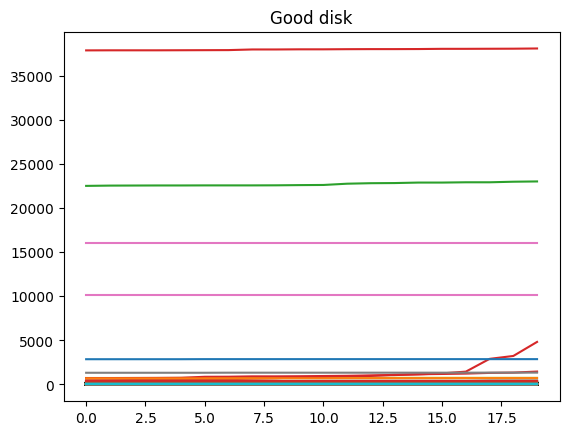

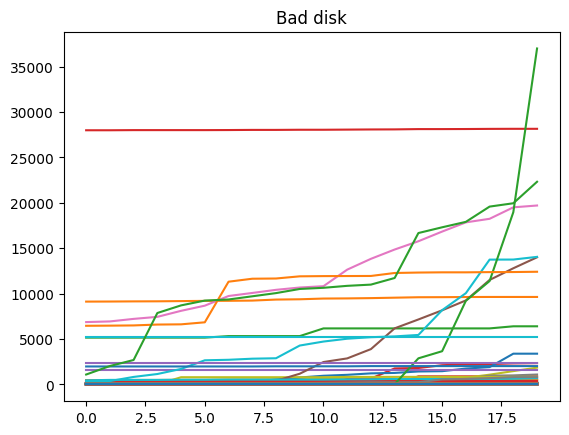

In [ ]:
# take lag(3) on smart 5 (rellocated sectors count)
smart = 5
plt.title("Good disk")
for _, data in good.groupby("serial_number"):
  plt.plot(list(range(20)), data[f"smart_{smart}_raw"].values)
plt.show()

plt.title("Bad disk")
for _, data in bad.groupby("serial_number"):
  plt.plot(list(range(20)), data[f"smart_{smart}_raw"].values)

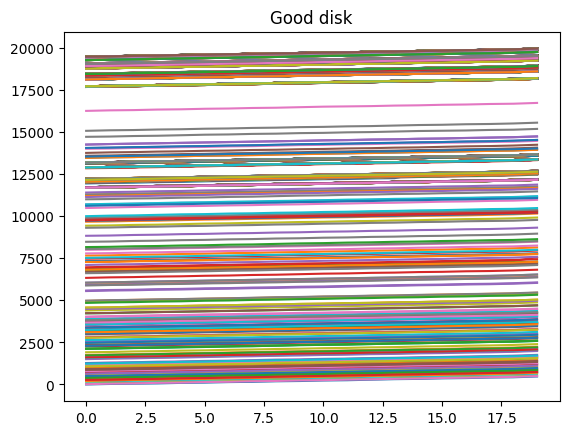

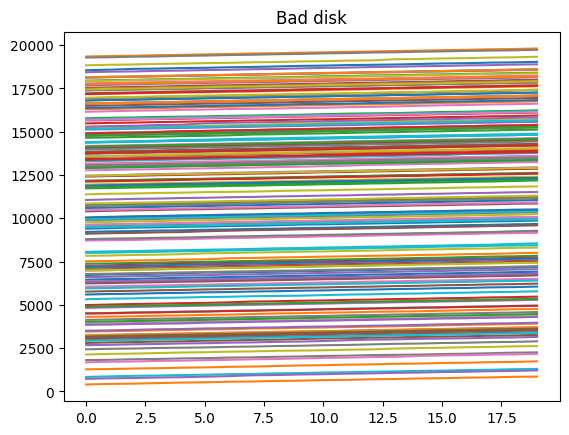

In [ ]:
# take only a raw value (Power-On Hours)
smart = 9
plt.title("Good disk")
for _, data in good.groupby("serial_number"):
  plt.plot(list(range(20)), data[f"smart_{smart}_raw"].values)
plt.show()

plt.title("Bad disk")
for _, data in bad.groupby("serial_number"):
  plt.plot(list(range(20)), data[f"smart_{smart}_raw"].values)

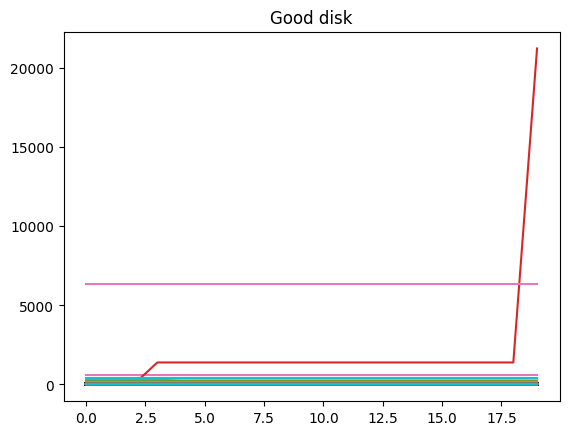

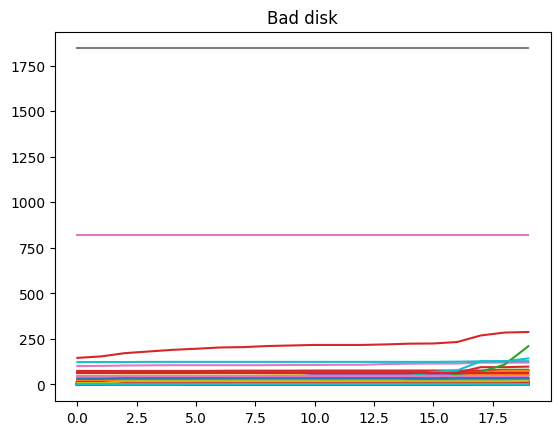

In [ ]:
# take a raw value (Reported UNC Errors)
smart = 187
plt.title("Good disk")
for _, data in good.groupby("serial_number"):
  plt.plot(list(range(20)), data[f"smart_{smart}_raw"].values)
plt.show()

plt.title("Bad disk")
for _, data in bad.groupby("serial_number"):
  plt.plot(list(range(20)), data[f"smart_{smart}_raw"].values)

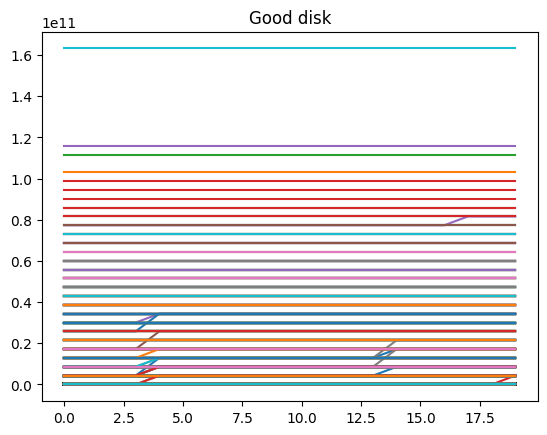

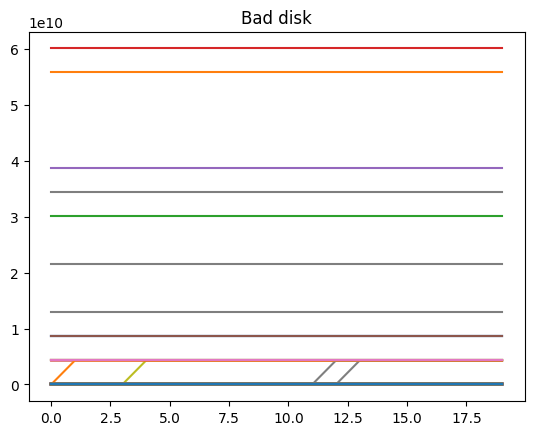

In [ ]:
# take a raw value (Command Timeout)
smart = 188
plt.title("Good disk")
for _, data in good.groupby("serial_number"):
  plt.plot(list(range(20)), data[f"smart_{smart}_raw"].values)
plt.show()

plt.title("Bad disk")
for _, data in bad.groupby("serial_number"):
  plt.plot(list(range(20)), data[f"smart_{smart}_raw"].values)

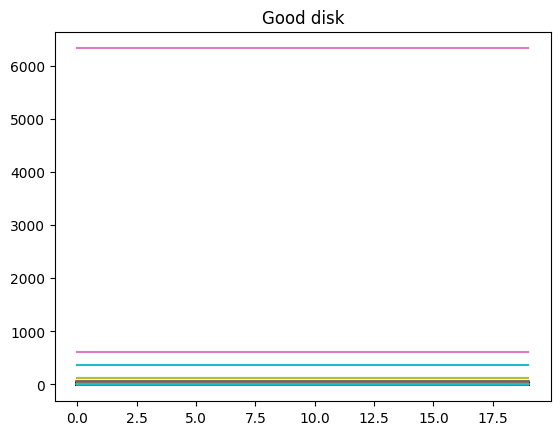

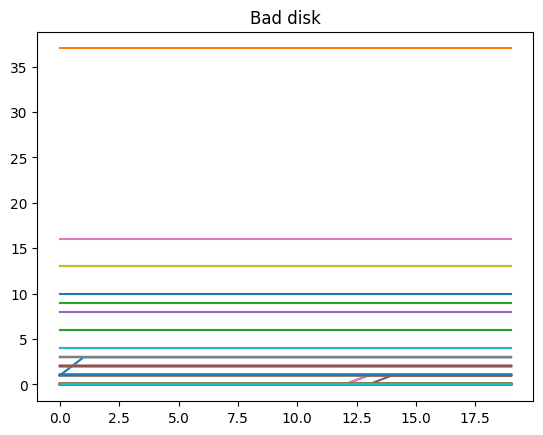

In [ ]:
# take a raw value (Power-off retract count)
smart = 192
plt.title("Good disk")
for _, data in good.groupby("serial_number"):
  plt.plot(list(range(20)), data[f"smart_{smart}_raw"].values / data["smart_9_raw"].values)
plt.show()

plt.title("Bad disk")
for _, data in bad.groupby("serial_number"):
  plt.plot(list(range(20)), data[f"smart_{smart}_raw"].values / data["smart_9_raw"].values)

<ipython-input-75-70d8e0f0ad2f>:5: RuntimeWarning: invalid value encountered in divide
  plt.plot(list(range(20)), data[f"smart_{smart}_raw"].values / data["smart_9_raw"].values)


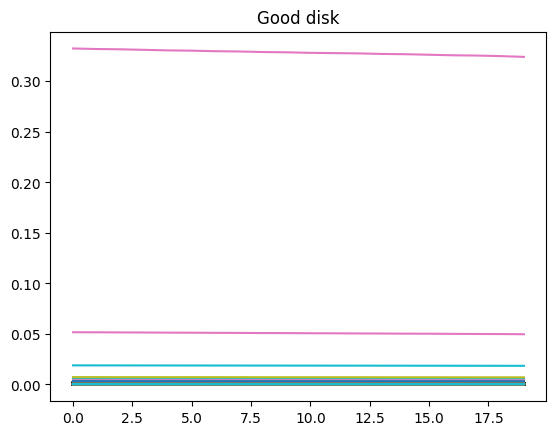

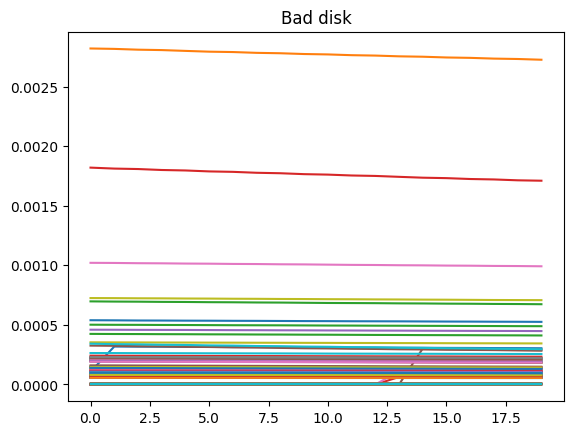

In [ ]:
# (Power-off retract count divided by workhour time)
smart = 192
plt.title("Good disk")
for _, data in good.groupby("serial_number"):
  plt.plot(list(range(20)), data[f"smart_{smart}_raw"].values / data["smart_9_raw"].values)
plt.show()

plt.title("Bad disk")
for _, data in bad.groupby("serial_number"):
  plt.plot(list(range(20)), data[f"smart_{smart}_raw"].values / data["smart_9_raw"].values)

<ipython-input-78-2188e4c7323b>:6: RuntimeWarning: invalid value encountered in divide
  plt.plot(list(range(20)), data[f"smart_{smart}_raw"].values.cumsum() / data["smart_9_raw"].values)


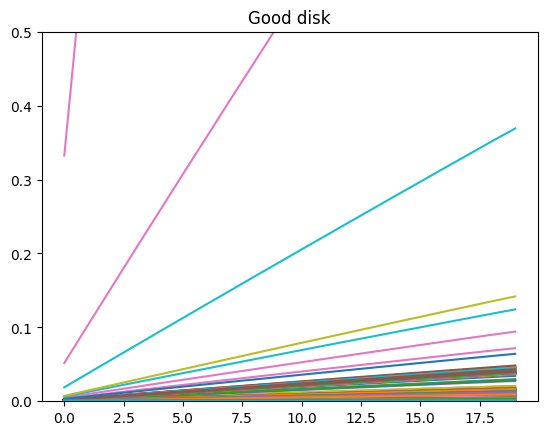

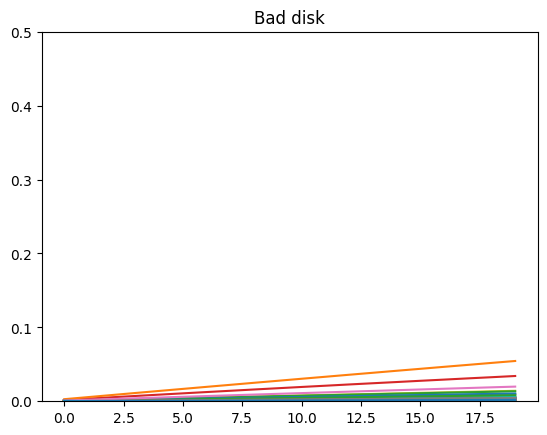

In [ ]:
# take a raw value (Power-off retract cumsum divied by workhour time)
smart = 192
plt.title("Good disk")
plt.ylim((0., 0.5))
for _, data in good.groupby("serial_number"):
  plt.plot(list(range(20)), data[f"smart_{smart}_raw"].values.cumsum() / data["smart_9_raw"].values)
plt.show()

plt.title("Bad disk")
plt.ylim((0., 0.5))
for _, data in bad.groupby("serial_number"):
  plt.plot(list(range(20)), data[f"smart_{smart}_raw"].values.cumsum() / data["smart_9_raw"].values)

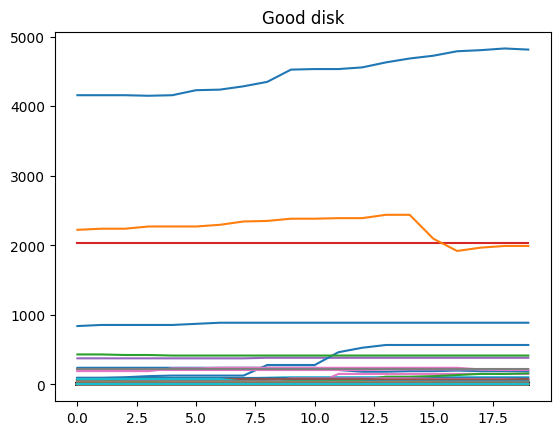

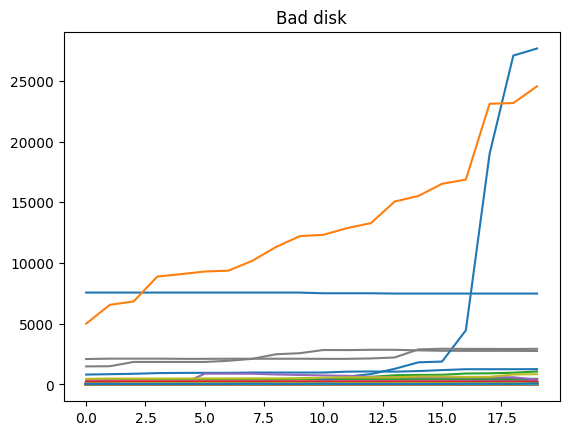

In [ ]:
# take a raw value (Current Pending Sector Count)
smart = 197
plt.title("Good disk")
for _, data in good.groupby("serial_number"):
  plt.plot(list(range(20)), data[f"smart_{smart}_raw"].values)
plt.show()

plt.title("Bad disk")
for _, data in bad.groupby("serial_number"):
  plt.plot(list(range(20)), data[f"smart_{smart}_raw"].values)

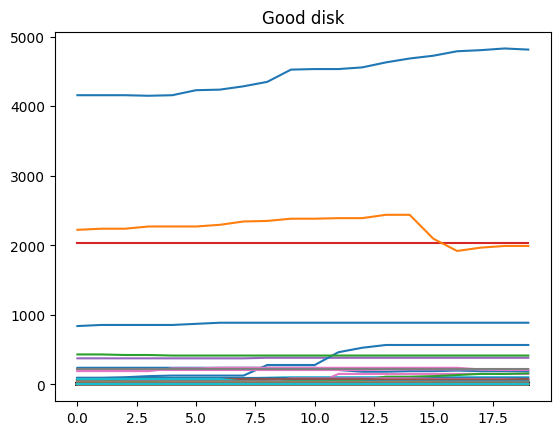

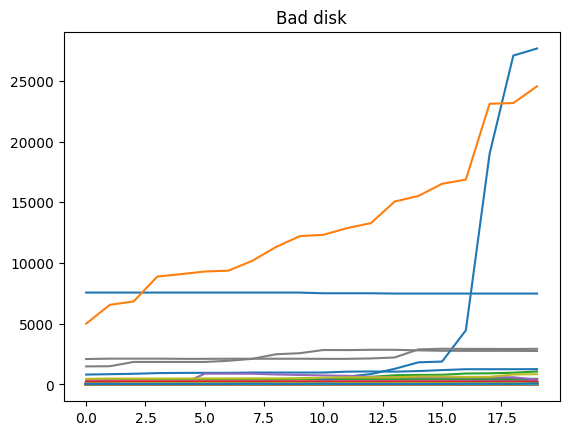

In [ ]:
# take a raw value (Uncorrectable Sector Count) it's exactly smart 197
smart = 198
plt.title("Good disk")
for _, data in good.groupby("serial_number"):
  plt.plot(list(range(20)), data[f"smart_{smart}_raw"].values)
plt.show()

plt.title("Bad disk")
for _, data in bad.groupby("serial_number"):
  plt.plot(list(range(20)), data[f"smart_{smart}_raw"].values)

In [ ]:
# take a raw value (SATA R-Errors Error Count)
smart = 199
plt.title("Good disk")
for _, data in good.groupby("serial_number"):
  plt.plot(list(range(20)), data[f"smart_{smart}_raw"].values)
plt.show()

plt.title("Bad disk")
for _, data in bad.groupby("serial_number"):
  plt.plot(list(range(20)), data[f"smart_{smart}_raw"].values)

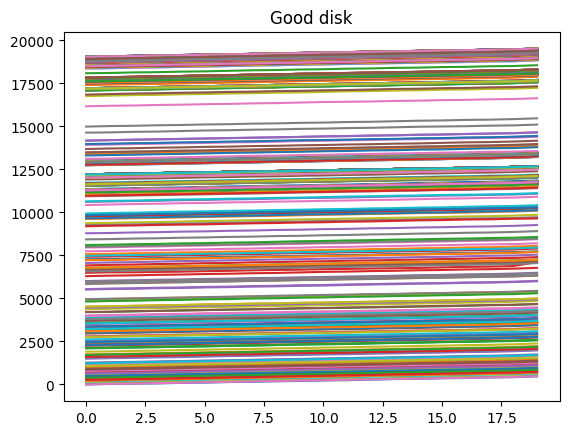

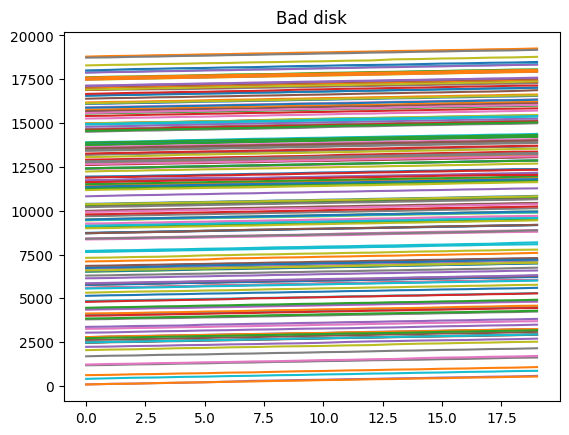

In [ ]:
# take a raw value (Head flying hours)
smart = 240
plt.title("Good disk")
for _, data in good.groupby("serial_number"):
  plt.plot(list(range(20)), data[f"smart_{smart}_raw"].values)
plt.show()

plt.title("Bad disk")
for _, data in bad.groupby("serial_number"):
  plt.plot(list(range(20)), data[f"smart_{smart}_raw"].values)

<ipython-input-91-79ea33606d9f>:6: RuntimeWarning: invalid value encountered in divide
  plt.plot(list(range(20)), data[f"smart_{smart}_raw"].values / data.smart_9_raw.values)


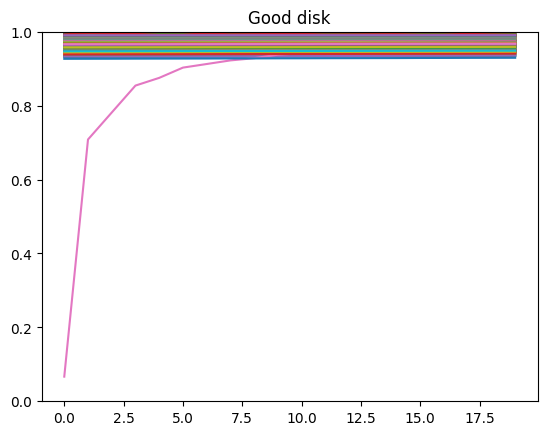

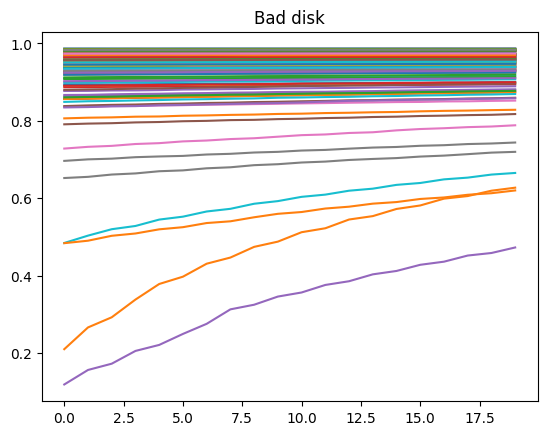

In [ ]:
# take a raw value (Head flying hours divided by workhour time)
smart = 240
plt.title("Good disk")
plt.ylim((0., 1.))
for _, data in good.groupby("serial_number"):
  plt.plot(list(range(20)), data[f"smart_{smart}_raw"].values / data.smart_9_raw.values)
plt.show()

plt.title("Bad disk")
for _, data in bad.groupby("serial_number"):
  plt.plot(list(range(20)), data[f"smart_{smart}_raw"].values / data.smart_9_raw.values)

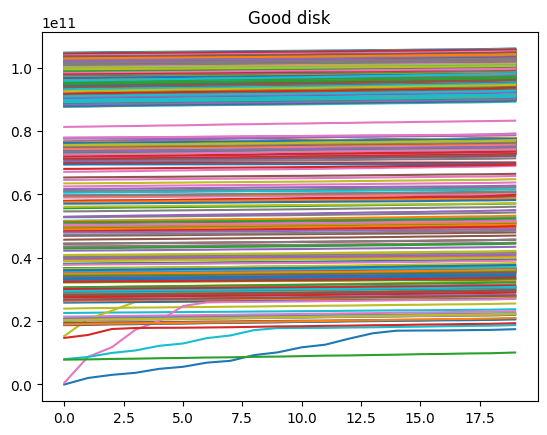

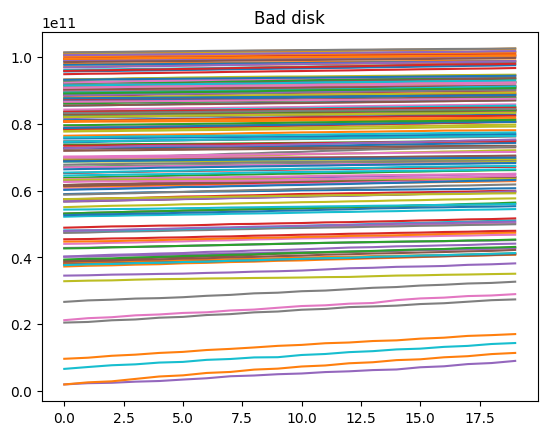

In [ ]:
# take a raw value (Total LBAs Written)
smart = 241
plt.title("Good disk")
for _, data in good.groupby("serial_number"):
  plt.plot(list(range(20)), data[f"smart_{smart}_raw"].values)
plt.show()

plt.title("Bad disk")
for _, data in bad.groupby("serial_number"):
  plt.plot(list(range(20)), data[f"smart_{smart}_raw"].values)

<ipython-input-109-f531ccaf3e6c>:6: RuntimeWarning: invalid value encountered in divide
  plt.plot(list(range(20)), data.smart_197_raw.values / data[f"smart_{smart}_raw"].values)


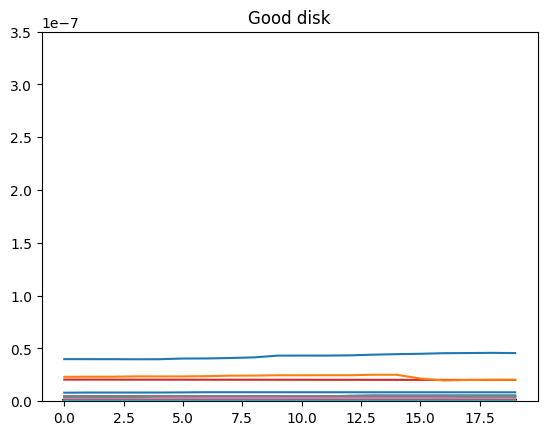

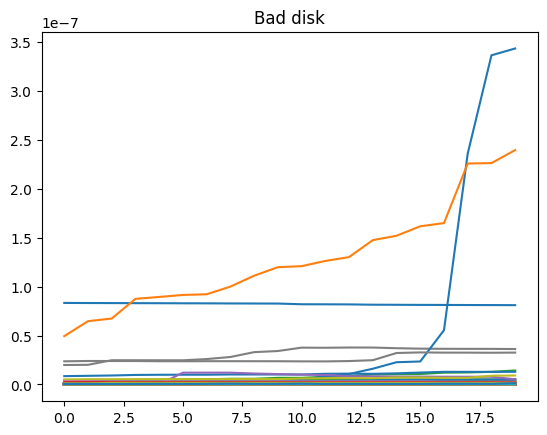

In [ ]:
# take a raw value (Current Pending Sector Count divided by Total LBAs Written)
smart = 241
plt.title("Good disk")
plt.ylim((0., 3.5e-7))
for _, data in good.groupby("serial_number"):
  plt.plot(list(range(20)), data.smart_197_raw.values / data[f"smart_{smart}_raw"].values)
plt.show()

plt.title("Bad disk")
for _, data in bad.groupby("serial_number"):
  plt.plot(list(range(20)), data.smart_197_raw.values / data[f"smart_{smart}_raw"].values)

<ipython-input-110-d92983c80664>:6: RuntimeWarning: invalid value encountered in divide
  plt.plot(list(range(20)), data.smart_198_raw.values / data[f"smart_{smart}_raw"].values)


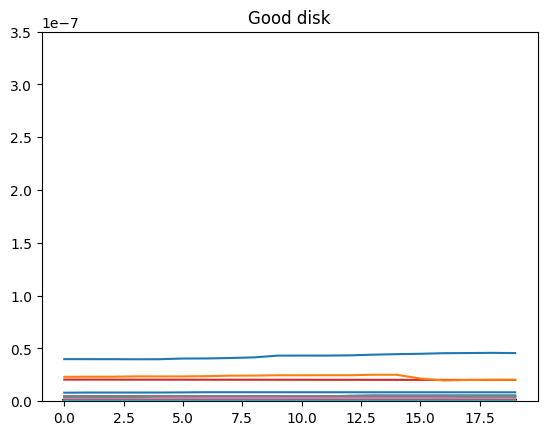

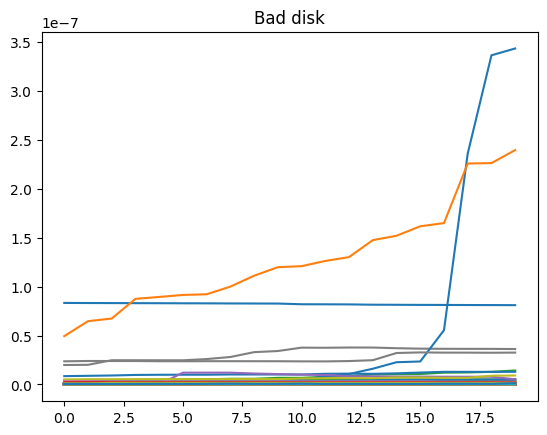

In [ ]:
# take a raw value (Uncorrectable Sector Count divided by Total LBAs Written)
smart = 241
plt.title("Good disk")
plt.ylim((0., 3.5e-7))
for _, data in good.groupby("serial_number"):
  plt.plot(list(range(20)), data.smart_198_raw.values / data[f"smart_{smart}_raw"].values)
plt.show()

plt.title("Bad disk")
for _, data in bad.groupby("serial_number"):
  plt.plot(list(range(20)), data.smart_198_raw.values / data[f"smart_{smart}_raw"].values)

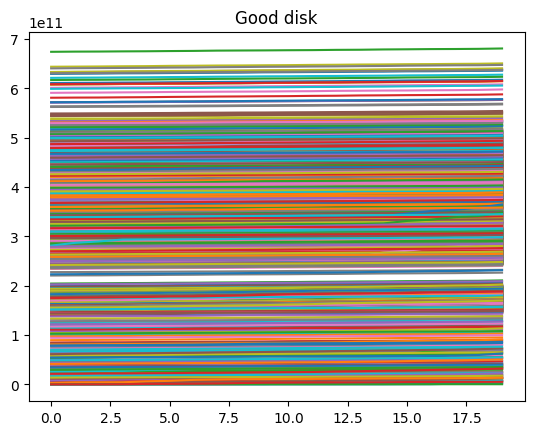

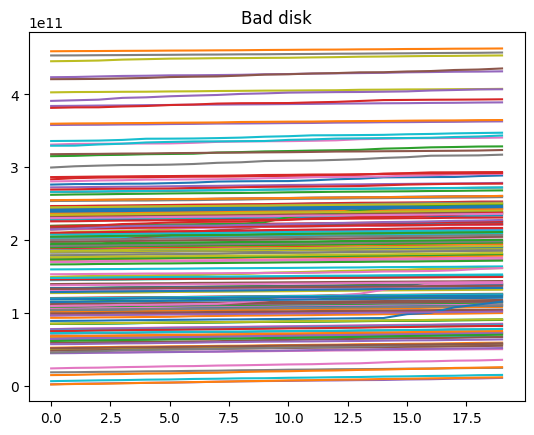

In [ ]:
# take a raw value (Total LBAs Read)
smart = 242
plt.title("Good disk")
for _, data in good.groupby("serial_number"):
  plt.plot(list(range(20)), data[f"smart_{smart}_raw"].values)
plt.show()

plt.title("Bad disk")
for _, data in bad.groupby("serial_number"):
  plt.plot(list(range(20)), data[f"smart_{smart}_raw"].values)

<ipython-input-113-7450cd760679>:5: RuntimeWarning: divide by zero encountered in divide
  plt.plot(list(range(20)), data[f"smart_{smart}_raw"].values / data.smart_241_raw.values)


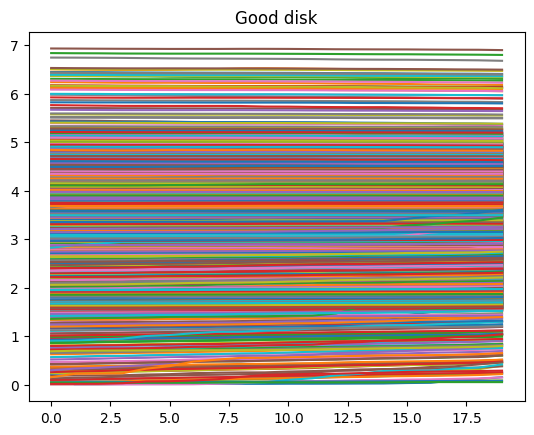

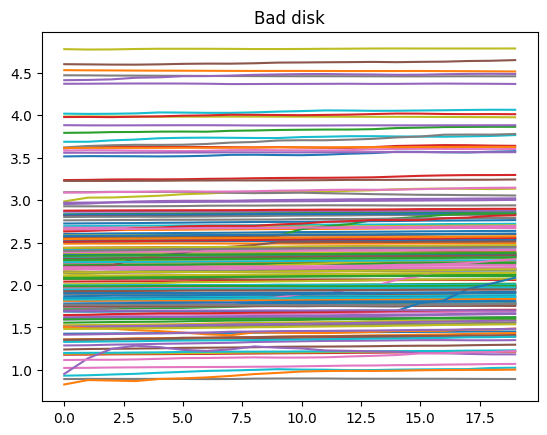

In [ ]:
# (Total LBAs Read divided by Total LBAs Written)
smart = 242
plt.title("Good disk")
for _, data in good.groupby("serial_number"):
  plt.plot(list(range(20)), data[f"smart_{smart}_raw"].values / data.smart_241_raw.values)
plt.show()

plt.title("Bad disk")
for _, data in bad.groupby("serial_number"):
  plt.plot(list(range(20)), data[f"smart_{smart}_raw"].values / data.smart_241_raw.values)

## Explore features

In [74]:
df_last_days = pd.read_csv("last_41_days.csv").drop("Unnamed: 0", axis=1)\
    .sort_values(["serial_number", "date"])
df = pd.read_csv("31_days_lag_fix.csv", parse_dates=["date"], index_col="num_day")

In [81]:
num_cols = df_last_days.select_dtypes(np.number)\
    .drop(["capacity_bytes", "failure"], axis=1).columns.to_list()

def diff(group):
    if group.name in num_cols:
        result = group.diff()
    else:
        result = group
    return result


diff_table = df_last_days.groupby('serial_number').transform(
    diff
).drop(["model", "capacity_bytes"], axis=1)

diff_table = pd.concat([df_last_days.loc[:, "serial_number"], diff_table], axis=1).dropna(axis=0)

In [110]:
num_cols = df_last_days.select_dtypes(np.number)\
    .drop(["capacity_bytes", "failure"], axis=1).columns.to_list()

def rolling(group, win_size: int):
    if group.name in num_cols:
        diff = group.diff().abs()
        result = diff.rolling(
            window=win_size, min_periods=1, win_type="exponential"
        ).mean(center=win_size, tau=1.5, sym=False)
    else:
        result = group
    return result


roll_table = df_last_days.groupby('serial_number').transform(
    rolling, 7
).drop(["model", "capacity_bytes"], axis=1)

roll_table = pd.concat([df_last_days.loc[:, "serial_number"], roll_table], axis=1).dropna(axis=0)

In [111]:
first_diff = diff_table.sort_values(["serial_number", "date"]).groupby("serial_number").head(1)
first_day = df_last_days.sort_values(["serial_number", "date"]).groupby("serial_number").head(1)
first_roll = roll_table.sort_values(["serial_number", "date"]).groupby("serial_number").head(1)

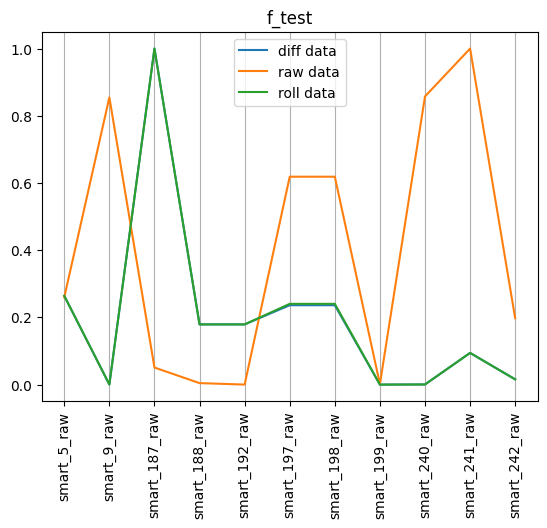

In [122]:
ftest_diff, _ = f_classif(first_diff.select_dtypes(np.number).drop("failure", axis=1), first_diff.failure)
ftest_orig, _ = f_classif(
    first_day.select_dtypes(np.number).drop(["failure", "capacity_bytes"], axis=1),
    first_day.failure
)
ftest_roll, _ = f_classif(
    first_roll.select_dtypes(np.number).drop(["failure"], axis=1),
    first_roll.failure
)
plt.plot(ftest_diff / np.max(ftest_diff), label="diff data")
plt.plot(ftest_orig / np.max(ftest_orig), label="raw data")
plt.plot(ftest_roll / np.max(ftest_roll), label="roll data")
plt.xticks(
    ticks=range(11),
    labels=first_diff.select_dtypes(np.number).drop("failure", axis=1).columns.to_list(),
    rotation=90
)
plt.grid(axis="x")
plt.legend()
plt.title("f_test")
plt.show()

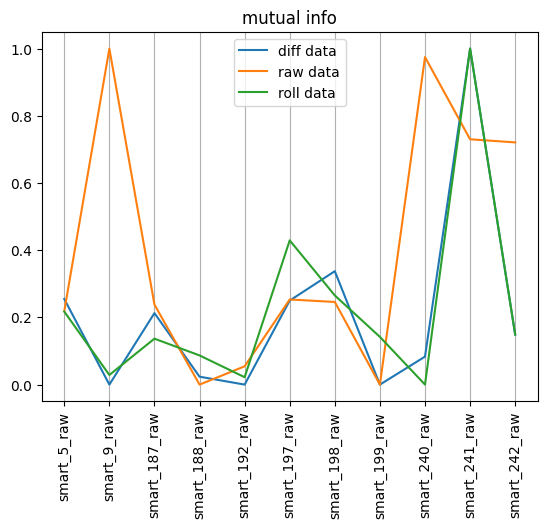

In [132]:
mi_diff = mutual_info_classif(first_diff.select_dtypes(np.number).drop("failure", axis=1), first_diff.failure)
mi_orig = mutual_info_classif(
    first_day.select_dtypes(np.number).drop(["failure", "capacity_bytes"], axis=1),
    first_day.failure
)
mi_roll = mutual_info_classif(
    first_roll.select_dtypes(np.number).drop(["failure"], axis=1),
    first_roll.failure
)
plt.plot(mi_diff / np.max(mi_diff), label="diff data")
plt.plot(mi_orig / np.max(mi_orig), label="raw data")
plt.plot(mi_roll / np.max(mi_roll), label="roll data")
plt.xticks(
    ticks=range(11),
    labels=first_diff.select_dtypes(np.number).drop("failure", axis=1).columns.to_list(),
    rotation=90
)
plt.grid(axis="x")
plt.legend()
plt.title("mutual info")
plt.show()

In [93]:
good = first_diff[first_diff.failure == 0]
bad = first_diff[first_diff.failure == 1]

In [ ]:
for raw in first_diff.select_dtypes(np.number).drop("failure", axis=1).columns:
    plt.hist(good.loc[:, raw], label="good")
    plt.hist(bad.loc[:, raw], label="bad")
    # plt.xlim((-0.5, 100))
    plt.title(str(raw))
    plt.legend()
    plt.show()

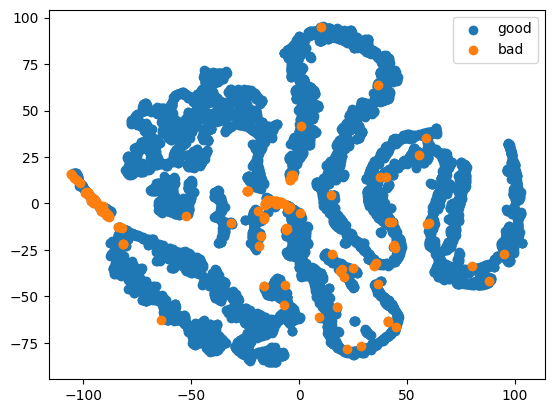

In [61]:
from sklearn.manifold import TSNE

data = TSNE(2).fit_transform(df.loc[1, [
    'smart_5_raw', 'smart_9_raw', 'smart_187_raw', 'smart_188_raw',
    'smart_192_raw', 'smart_197_raw', 'smart_198_raw', 'smart_199_raw',
    'smart_240_raw', 'smart_241_raw', 'smart_242_raw'
]])
plt.scatter(data[df.loc[1].failure == 0][:, 0], data[df.loc[1].failure == 0][:, 1], label="good")
plt.scatter(data[df.loc[1].failure == 1][:, 0], data[df.loc[1].failure == 1][:, 1], label="bad")
plt.legend()
plt.show()

## Add new features

In [134]:
# df_last_days = pd.read_csv("last_41_days.csv").drop("Unnamed: 0", axis=1)
df_last_days = pd.read_csv("last_44_days.csv")

In [135]:
num_cols = df_last_days.select_dtypes(np.number)\
    .drop(["capacity_bytes", "failure"], axis=1).columns.to_list()

def rolling(group, win_size: int):
    if group.name in num_cols:
        diff = group.diff().abs()
        result = diff.rolling(
            window=win_size, min_periods=1, win_type="exponential"
        ).mean(center=win_size, tau=1.5, sym=False)
    else:
        result = group
    return result


def lag(group, lg: int):
    if group.name in num_cols:
        result = group.shift(lg)
        result.name = group.name + f"_lag_{lg}"
    else:
        result = group
    return result


smart_192_div_9 = pd.DataFrame(np.array([
    data.smart_192_raw.values.cumsum() / data.smart_9_raw.values
    for _, data in df_last_days.groupby("serial_number")
]).flatten(), columns=["smart_192cumul_div_9"])

smart_240_div_9 = pd.DataFrame(np.array([
    data.smart_240_raw.values / data.smart_9_raw.values
    for _, data in df_last_days.groupby("serial_number")
]).flatten(), columns=["smart_240_div_9"])

smart_197_div_241 = pd.DataFrame(np.array([
    data.smart_197_raw.values / data.smart_241_raw.values
    for _, data in df_last_days.groupby("serial_number")
]).flatten(), columns=["smart_197_div_241"])

smart_198_div_241 = pd.DataFrame(np.array([
    data.smart_198_raw.values / data.smart_241_raw.values
    for _, data in df_last_days.groupby("serial_number")
]).flatten(), columns=["smart_198_div_241"])

smart_242_div_241 = pd.DataFrame(np.array([
    data.smart_242_raw.values / data.smart_241_raw.values
    for _, data in df_last_days.groupby("serial_number")
]).flatten(), columns=["smart_242_div_241"])

lag3_table = df_last_days.groupby('serial_number').transform(
    lag, lg=3
).drop(["date", "model", "failure", "capacity_bytes"], axis=1)
lag3_table.columns = [col + "_lag_3" for col in num_cols]

lag5_table = df_last_days.groupby('serial_number').transform(
    lag, lg=5
).drop(["date", "model", "failure", "capacity_bytes"], axis=1)
lag5_table.columns = [col + "_lag_5" for col in num_cols]

lag7_table = df_last_days.groupby('serial_number').transform(
    lag, lg=7
).drop(["date", "model", "failure", "capacity_bytes"], axis=1)
lag7_table.columns = [col + "_lag_7" for col in num_cols]

lag10_table = df_last_days.groupby('serial_number').transform(
    lag, lg=10
).drop(["date", "model", "failure", "capacity_bytes"], axis=1)
lag10_table.columns = [col + "_lag_10" for col in num_cols]

roll5_table = df_last_days.groupby('serial_number').transform(
    rolling, win_size=5
).drop(["date", "model", "failure", "capacity_bytes"], axis=1)
roll5_table.columns = [col + "_roll_5" for col in num_cols]

roll7_table = df_last_days.groupby('serial_number').transform(
    rolling, win_size=7
).drop(["date", "model", "failure", "capacity_bytes"], axis=1)
roll7_table.columns = [col + "_roll_7" for col in num_cols]

roll10_table = df_last_days.groupby('serial_number').transform(
    rolling, win_size=10
).drop(["date", "model", "failure", "capacity_bytes"], axis=1)
roll10_table.columns = [col + "_roll_10" for col in num_cols]

tmp = pd.concat([
    df_last_days, roll5_table, roll7_table, roll10_table,
    lag3_table, lag5_table, lag7_table, lag10_table,
    smart_192_div_9, smart_197_div_241, smart_198_div_241, smart_240_div_9,
    smart_242_div_241
], axis=1, join="inner").dropna(axis=0)
# tmp.to_csv("last_31_days_lag.csv", index=False)
tmp.to_csv("last_34_days_lag.csv", index=False)

In [136]:
len(set(tmp.serial_number).difference(set(df_last_days.serial_number)))

0

In [138]:
df_last_days = pd.read_csv("last_34_days_lag.csv", parse_dates=["date"])\
    .sort_values(by=["serial_number", "date"], ascending=[True, True])

num_day = df_last_days.loc[:, ["date", "serial_number"]].groupby("serial_number", sort=False)\
    .transform(
        lambda series: series if series.name == "serial_number" else list(range(1, series.shape[0] + 1))
    )
num_day.columns = ["num_day"]

pd.concat([num_day, df_last_days], axis=1, join="inner").to_csv("34_days_lag_fix.csv", index=False)

In [78]:
df_last_days = pd.read_csv("last_31_days_lag.csv", parse_dates=["date"])\
    .sort_values(by=["serial_number", "date"])

num_day = df_last_days.loc[:, ["date", "serial_number"]].groupby("serial_number", sort=False)\
    .transform(
        lambda series: series if series.name == "serial_number" else list(range(1, series.shape[0] + 1))
    )
num_day.columns = ["num_day"]

pd.concat([num_day, df_last_days], axis=1, join="inner").to_csv("31_days_lag_fix.csv", index=False)

In [52]:
lag_fix = pd.read_csv("31_days_lag_fix.csv", parse_dates=["date"])

In [53]:
len(set(tmp.serial_number).difference(set(lag_fix.serial_number)))

0

In [55]:
lag_fix.shape, tmp.shape

((338241, 99), (338241, 98))

# Work with data

## Functions

In [3]:
def TrainValTestSplit(
    df, y_data=None,
    ignore_cols=[
        "date", "model", "serial_number", "capacity_bytes", "failure"
    ]
):
    """
    return:
        if y_data is None:
            (x_train, x_val, x_test, y_train, y_val, y_test)
        else:
            (x_train, x_test, y_train, y_test)
    """
    if y_data is None:
        fail_models = set(df[df.failure == 1].serial_number)
        good_models = set(df.serial_number).difference(fail_models)

        df_good = df.loc[df.serial_number.isin(good_models)]
        df_bad = df.loc[df.serial_number.isin(fail_models)]

        df_good = df_good.sort_index()
        df_bad = df_bad.sort_index()

        good_y = df_good["failure"]
        bad_y = df_bad["failure"]
    else:
        df_good = df.loc[y_data == 0]
        df_bad = df.loc[y_data == 1]

        good_y = y_data[y_data == 0]
        bad_y = y_data[y_data == 1]

    # Split into train (60%), valid (20%) and test (20%)
    x_train_good, x_test_good, y_train_good, y_test_good = train_test_split(
        df_good, good_y, train_size=0.8, shuffle=False
    )
    x_train_bad, x_test_bad, y_train_bad, y_test_bad = train_test_split(
        df_bad, bad_y, train_size=0.8, shuffle=False
    )

    if y_data is None:
        x_train_good, x_val_good, y_train_good, y_val_good = train_test_split(
            x_train_good, y_train_good, test_size=0.25, shuffle=False
        )
        x_train_bad, x_val_bad, y_train_bad, y_val_bad = train_test_split(
            x_train_bad, y_train_bad, test_size=0.25, shuffle=False
        )

    x_train = pd.concat([x_train_good, x_train_bad], axis=0).sort_index()
    y_train = pd.concat([y_train_good, y_train_bad], axis=0).sort_index()
    x_test = pd.concat([x_test_good, x_test_bad], axis=0).sort_index()
    y_test = pd.concat([y_test_good, y_test_bad], axis=0).sort_index()

    if y_data is None:
        x_train.drop(ignore_cols, axis=1, inplace=True)

        x_val = pd.concat([x_val_good, x_val_bad], axis=0).sort_index()
        x_val.drop(ignore_cols, axis=1, inplace=True)
        y_val = pd.concat([y_val_good, y_val_bad], axis=0).sort_index()

        x_test.drop(ignore_cols, axis=1, inplace=True)

        return (x_train, x_val, x_test, y_train, y_val, y_test)

    return (x_train, x_test, y_train, y_test)

In [4]:
FEATURE_LIST = {
        "stats": [
            'smart_5_raw',
            'smart_9_raw',
            'smart_240_raw',
            'smart_241_raw',
            'smart_242_raw',
            'smart_241_raw_roll_10',
            'smart_5_raw_lag_3',
            'smart_9_raw_lag_3',
            'smart_240_raw_lag_3',
            'smart_241_raw_lag_3',
            'smart_242_raw_lag_3',
            'smart_5_raw_lag_5',
            'smart_9_raw_lag_5',
            'smart_240_raw_lag_5',
            'smart_241_raw_lag_5',
            'smart_242_raw_lag_5',
            'smart_9_raw_lag_7',
            'smart_240_raw_lag_7',
            'smart_241_raw_lag_7',
            'smart_242_raw_lag_7',
            'smart_9_raw_lag_10',
            'smart_240_raw_lag_10',
            'smart_241_raw_lag_10',
            'smart_242_raw_lag_10'
        ],
        "stats_without_lag": [
            'smart_5_raw',
            'smart_9_raw',
            'smart_240_raw',
            'smart_241_raw',
            'smart_242_raw'
        ],
        "stats_without_depend": [
            'smart_5_raw',
            'smart_9_raw',
            'smart_241_raw',
            'smart_242_raw',
            'smart_241_raw_roll_10',
            'smart_5_raw_lag_3',
            'smart_9_raw_lag_3',
            'smart_241_raw_lag_3',
            'smart_242_raw_lag_3',
            'smart_5_raw_lag_5',
            'smart_9_raw_lag_5',
            'smart_241_raw_lag_5',
            'smart_242_raw_lag_5',
            'smart_9_raw_lag_7',
            'smart_241_raw_lag_7',
            'smart_242_raw_lag_7',
            'smart_9_raw_lag_10',
            'smart_241_raw_lag_10',
            'smart_242_raw_lag_10'
        ],
        "f_test_feat": [
            'smart_5_raw', 'smart_9_raw', 'smart_240_raw', 'smart_241_raw',
            'smart_241_raw_roll_7', 'smart_241_raw_roll_10',
            'smart_5_raw_lag_3', 'smart_9_raw_lag_3', 'smart_240_raw_lag_3',
            'smart_241_raw_lag_3', 'smart_5_raw_lag_5', 'smart_9_raw_lag_5',
            'smart_240_raw_lag_5', 'smart_241_raw_lag_5', 'smart_9_raw_lag_7',
            'smart_240_raw_lag_7', 'smart_241_raw_lag_7', 'smart_9_raw_lag_10',
            'smart_240_raw_lag_10', 'smart_241_raw_lag_10'
       ],
       "mi_test_feat": [
           'smart_9_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw',
            'smart_9_raw_lag_3', 'smart_240_raw_lag_3', 'smart_241_raw_lag_3',
            'smart_242_raw_lag_3', 'smart_9_raw_lag_5', 'smart_240_raw_lag_5',
            'smart_241_raw_lag_5', 'smart_242_raw_lag_5', 'smart_9_raw_lag_7',
            'smart_240_raw_lag_7', 'smart_241_raw_lag_7',
            'smart_242_raw_lag_7', 'smart_9_raw_lag_10',
            'smart_240_raw_lag_10', 'smart_241_raw_lag_10',
            'smart_242_raw_lag_10'
       ],
        "paper": [
            'smart_5_raw',
            'smart_5_raw_roll_5',
            'smart_5_raw_roll_7',
            'smart_5_raw_roll_10',
            'smart_5_raw_lag_3',
            'smart_5_raw_lag_5',
            'smart_5_raw_lag_7',
            'smart_5_raw_lag_10',
            'smart_187_raw',
            'smart_187_raw_roll_5',
            'smart_187_raw_roll_7',
            'smart_187_raw_roll_10',
            'smart_187_raw_lag_3',
            'smart_187_raw_lag_5',
            'smart_187_raw_lag_7',
            'smart_187_raw_lag_10',
            'smart_188_raw',
            'smart_188_raw_roll_5',
            'smart_188_raw_roll_7',
            'smart_188_raw_roll_10',
            'smart_188_raw_lag_3',
            'smart_188_raw_lag_5',
            'smart_188_raw_lag_7',
            'smart_188_raw_lag_10',
            'smart_197_raw',
            'smart_197_raw_roll_5',
            'smart_197_raw_roll_7',
            'smart_197_raw_roll_10',
            'smart_197_raw_lag_3',
            'smart_197_raw_lag_5',
            'smart_197_raw_lag_7',
            'smart_197_raw_lag_10',
            'smart_198_raw',
            'smart_198_raw_roll_5',
            'smart_198_raw_roll_7',
            'smart_198_raw_roll_10',
            'smart_198_raw_lag_3',
            'smart_198_raw_lag_5',
            'smart_198_raw_lag_7',
            'smart_198_raw_lag_10'
        ],
        "paper_without_roll": [
            'smart_5_raw',
            'smart_5_raw_lag_3',
            'smart_5_raw_lag_5',
            'smart_5_raw_lag_7',
            'smart_5_raw_lag_10',
            'smart_187_raw',
            'smart_187_raw_lag_3',
            'smart_187_raw_lag_5',
            'smart_187_raw_lag_7',
            'smart_187_raw_lag_10',
            'smart_188_raw',
            'smart_188_raw_lag_3',
            'smart_188_raw_lag_5',
            'smart_188_raw_lag_7',
            'smart_188_raw_lag_10',
            'smart_197_raw',
            'smart_197_raw_lag_3',
            'smart_197_raw_lag_5',
            'smart_197_raw_lag_7',
            'smart_197_raw_lag_10',
            'smart_198_raw',
            'smart_198_raw_lag_3',
            'smart_198_raw_lag_5',
            'smart_198_raw_lag_7',
            'smart_198_raw_lag_10'
        ],
        "paper_without_lag": [
            'smart_5_raw',
            'smart_187_raw',
            'smart_188_raw',
            'smart_197_raw',
            'smart_198_raw',
        ],
        "paper_without_depend": [
            'smart_5_raw',
            'smart_5_raw_roll_5',
            'smart_5_raw_roll_7',
            'smart_5_raw_roll_10',
            'smart_5_raw_lag_3',
            'smart_5_raw_lag_5',
            'smart_5_raw_lag_7',
            'smart_5_raw_lag_10',
            'smart_187_raw',
            'smart_187_raw_roll_5',
            'smart_187_raw_roll_7',
            'smart_187_raw_roll_10',
            'smart_187_raw_lag_3',
            'smart_187_raw_lag_5',
            'smart_187_raw_lag_7',
            'smart_187_raw_lag_10',
            'smart_188_raw',
            'smart_188_raw_roll_5',
            'smart_188_raw_roll_7',
            'smart_188_raw_roll_10',
            'smart_188_raw_lag_3',
            'smart_188_raw_lag_5',
            'smart_188_raw_lag_7',
            'smart_188_raw_lag_10',
            'smart_197_raw',
            'smart_197_raw_roll_5',
            'smart_197_raw_roll_7',
            'smart_197_raw_roll_10',
            'smart_197_raw_lag_3',
            'smart_197_raw_lag_5',
            'smart_197_raw_lag_7',
            'smart_197_raw_lag_10'
        ],
        "elastic_logistic": [
            'smart_188_raw', 'smart_241_raw', 'smart_188_raw_roll_5',
            'smart_241_raw_roll_5', 'smart_188_raw_roll_7',
            'smart_241_raw_roll_7', 'smart_188_raw_roll_10',
            'smart_241_raw_roll_10', 'smart_241_raw_lag_3',
            'smart_242_raw_lag_5', 'smart_188_raw_lag_7',
            'smart_241_raw_lag_7', 'smart_188_raw_lag_10',
            'smart_241_raw_lag_10'
        ],
        "elastic_logistic_1st_day": [
            'smart_188_raw', 'smart_241_raw', 'smart_242_raw',
            'smart_241_raw_roll_5', 'smart_242_raw_roll_5',
            'smart_241_raw_roll_7', 'smart_242_raw_roll_7',
            'smart_241_raw_roll_10', 'smart_242_raw_roll_10',
            'smart_188_raw_lag_3', 'smart_241_raw_lag_3',
            'smart_242_raw_lag_3', 'smart_188_raw_lag_5',
            'smart_241_raw_lag_7', 'smart_242_raw_lag_7',
            'smart_188_raw_lag_10', 'smart_241_raw_lag_10',
            'smart_242_raw_lag_10'
        ],
        "xgb_weight30": [
            'smart_240_div_9',
            'smart_9_raw',
            'smart_241_raw',
            'smart_242_div_241',
            'smart_187_raw',
            'smart_242_raw_lag_10',
            'smart_240_raw',
            'smart_242_raw',
            'smart_5_raw',
            'smart_241_raw_lag_10',
            'smart_9_raw_lag_3',
            'smart_197_div_241',
            'smart_192_raw',
            'smart_9_raw_lag_10',
            'smart_242_raw_lag_3',
            'smart_241_raw_roll_5',
            'smart_192cumul_div_9',
            'smart_5_raw_roll_10',
            'smart_242_raw_lag_7',
            'smart_5_raw_roll_5',
            'smart_197_raw_roll_10',
            'smart_242_raw_roll_5'
        ],
        "xgb_weight30_1_day": [
            'smart_9_raw',
            'smart_240_div_9',
            'smart_242_div_241',
            'smart_240_raw',
            'smart_241_raw',
            'smart_187_raw',
            'smart_241_raw_roll_7',
            'smart_241_raw_roll_5',
            'smart_242_raw_lag_10',
            'smart_5_raw',
            'smart_242_raw',
            'smart_9_raw_roll_10',
            'smart_242_raw_roll_5',
            'smart_9_raw_roll_5',
            'smart_5_raw_roll_5',
            'smart_197_div_241',
            'smart_240_raw_roll_7'
        ],
        "xgb_gain30": [
            'smart_197_raw_roll_10',
            'smart_187_raw',
            'smart_9_raw_lag_10',
            'smart_9_raw_lag_3',
            'smart_5_raw_roll_10',
            'smart_197_div_241',
            'smart_240_div_9',
            'smart_5_raw_lag_5',
            'smart_9_raw_lag_5',
            'smart_5_raw_lag_3',
            'smart_9_raw',
            'smart_242_raw_lag_3',
            'smart_241_raw',
            'smart_240_raw',
            'smart_240_raw_lag_3',
            'smart_187_raw_roll_5',
            'smart_241_raw_lag_7',
            'smart_242_raw_lag_10',
            'smart_187_raw_roll_10',
            'smart_241_raw_lag_5',
            'smart_241_raw_lag_10',
            'smart_242_raw_lag_7'
        ],
        "xgb_gain30_1_day": [
            'smart_197_raw_roll_10',
            'smart_242_raw_lag_3',
            'smart_197_div_241',
            'smart_240_div_9',
            'smart_187_raw_lag_7',
            'smart_187_raw',
            'smart_5_raw_roll_5',
            'smart_9_raw',
            'smart_242_raw_lag_10',
            'smart_240_raw',
            'smart_242_raw_lag_7',
            'smart_197_raw_roll_5',
            'smart_197_raw',
            'smart_5_raw',
            'smart_5_raw_lag_5',
            'smart_241_raw_roll_10',
            'smart_241_raw'
        ],
        "xgb_total_gain30": [
            'smart_240_div_9',
            'smart_187_raw',
            'smart_9_raw',
            'smart_9_raw_lag_3',
            'smart_241_raw',
            'smart_9_raw_lag_10',
            'smart_197_div_241',
            'smart_197_raw_roll_10',
            'smart_5_raw_roll_10',
            'smart_240_raw',
            'smart_242_raw_lag_10',
            'smart_242_div_241',
            'smart_242_raw_lag_3',
            'smart_242_raw',
            'smart_9_raw_lag_5',
            'smart_241_raw_lag_10',
            'smart_5_raw_lag_3',
            'smart_5_raw',
            'smart_240_raw_lag_3',
            'smart_242_raw_lag_7',
            'smart_187_raw_roll_10',
            'smart_192_raw'
        ],
        "xgb_total_gain30_1_day": [
            'smart_240_div_9',
            'smart_9_raw',
            'smart_187_raw',
            'smart_240_raw',
            'smart_197_div_241',
            'smart_197_raw_roll_10',
            'smart_242_raw_lag_10',
            'smart_241_raw',
            'smart_5_raw_roll_5',
            'smart_242_raw_lag_3',
            'smart_5_raw',
            'smart_242_div_241',
            'smart_241_raw_roll_7',
            'smart_242_raw',
            'smart_242_raw_lag_7',
            'smart_187_raw_lag_7',
            'smart_9_raw_roll_10'
        ],
        "xgb_cover30": [
            'smart_5_raw_roll_10',
            'smart_197_div_241',
            'smart_197_raw_roll_10',
            'smart_240_raw',
            'smart_187_raw',
            'smart_9_raw_lag_5',
            'smart_197_raw_lag_7',
            'smart_9_raw_lag_3',
            'smart_240_raw_roll_7',
            'smart_5_raw_roll_5',
            'smart_240_div_9',
            'smart_197_raw_lag_10',
            'smart_240_raw_lag_3',
            'smart_242_raw_lag_7',
            'smart_5_raw_lag_3',
            'smart_242_raw_lag_3',
            'smart_197_raw_roll_5',
            'smart_5_raw_lag_7',
            'smart_242_raw_lag_10',
            'smart_5_raw_roll_7',
            'smart_9_raw_lag_10',
            'smart_197_raw_lag_3'
        ],
        "xgb_cover30_1_day": [
            'smart_197_raw_roll_10',
            'smart_187_raw_lag_7',
            'smart_5_raw_roll_5',
            'smart_197_div_241',
            'smart_9_raw_roll_10',
            'smart_197_raw_roll_5',
            'smart_241_raw_roll_7',
            'smart_187_raw',
            'smart_187_raw_lag_5',
            'smart_240_raw',
            'smart_240_div_9',
            'smart_5_raw',
            'smart_9_raw',
            'smart_241_raw_lag_10',
            'smart_199_raw',
            'smart_241_raw_roll_10',
            'smart_242_raw_roll_5'
        ],
        "sequential_selector": [
            'smart_5_raw', 'smart_9_raw', 'smart_187_raw', 'smart_188_raw',
            'smart_192_raw', 'smart_197_raw', 'smart_198_raw', 'smart_199_raw',
            'smart_240_raw', 'smart_241_raw', 'smart_242_raw',
            'smart_5_raw_roll_5', 'smart_9_raw_roll_5', 'smart_187_raw_roll_5',
            'smart_188_raw_roll_5', 'smart_192_raw_roll_5',
            'smart_197_raw_roll_5'
       ],
        "default": [
            'smart_5_raw',
            'smart_9_raw',
            'smart_187_raw',
            'smart_188_raw',
            'smart_192_raw',
            'smart_197_raw',
            'smart_198_raw',
            'smart_199_raw',
            'smart_240_raw',
            'smart_241_raw',
            'smart_242_raw',
            'smart_5_raw_roll_5',
            'smart_9_raw_roll_5',
            'smart_187_raw_roll_5',
            'smart_188_raw_roll_5',
            'smart_192_raw_roll_5',
            'smart_197_raw_roll_5',
            'smart_198_raw_roll_5',
            'smart_199_raw_roll_5',
            'smart_240_raw_roll_5',
            'smart_241_raw_roll_5',
            'smart_242_raw_roll_5',
            'smart_5_raw_roll_7',
            'smart_9_raw_roll_7',
            'smart_187_raw_roll_7',
            'smart_188_raw_roll_7',
            'smart_192_raw_roll_7',
            'smart_197_raw_roll_7',
            'smart_198_raw_roll_7',
            'smart_199_raw_roll_7',
            'smart_240_raw_roll_7',
            'smart_241_raw_roll_7',
            'smart_242_raw_roll_7',
            'smart_5_raw_roll_10',
            'smart_9_raw_roll_10',
            'smart_187_raw_roll_10',
            'smart_188_raw_roll_10',
            'smart_192_raw_roll_10',
            'smart_197_raw_roll_10',
            'smart_198_raw_roll_10',
            'smart_199_raw_roll_10',
            'smart_240_raw_roll_10',
            'smart_241_raw_roll_10',
            'smart_242_raw_roll_10',
            'smart_5_raw_lag_3',
            'smart_9_raw_lag_3',
            'smart_187_raw_lag_3',
            'smart_188_raw_lag_3',
            'smart_192_raw_lag_3',
            'smart_197_raw_lag_3',
            'smart_198_raw_lag_3',
            'smart_199_raw_lag_3',
            'smart_240_raw_lag_3',
            'smart_241_raw_lag_3',
            'smart_242_raw_lag_3',
            'smart_5_raw_lag_5',
            'smart_9_raw_lag_5',
            'smart_187_raw_lag_5',
            'smart_188_raw_lag_5',
            'smart_192_raw_lag_5',
            'smart_197_raw_lag_5',
            'smart_198_raw_lag_5',
            'smart_199_raw_lag_5',
            'smart_240_raw_lag_5',
            'smart_241_raw_lag_5',
            'smart_242_raw_lag_5',
            'smart_5_raw_lag_7',
            'smart_9_raw_lag_7',
            'smart_187_raw_lag_7',
            'smart_188_raw_lag_7',
            'smart_192_raw_lag_7',
            'smart_197_raw_lag_7',
            'smart_198_raw_lag_7',
            'smart_199_raw_lag_7',
            'smart_240_raw_lag_7',
            'smart_241_raw_lag_7',
            'smart_242_raw_lag_7',
            'smart_5_raw_lag_10',
            'smart_9_raw_lag_10',
            'smart_187_raw_lag_10',
            'smart_188_raw_lag_10',
            'smart_192_raw_lag_10',
            'smart_197_raw_lag_10',
            'smart_198_raw_lag_10',
            'smart_199_raw_lag_10',
            'smart_240_raw_lag_10',
            'smart_241_raw_lag_10',
            'smart_242_raw_lag_10',
            'smart_192cumul_div_9',
            'smart_197_div_241',
            'smart_198_div_241',
            'smart_240_div_9',
            'smart_242_div_241'
        ],
        "default_without_lag": [
            'smart_5_raw', 'smart_9_raw', 'smart_187_raw', 'smart_188_raw',
            'smart_192_raw', 'smart_197_raw', 'smart_198_raw', 'smart_199_raw',
            'smart_240_raw', 'smart_241_raw', 'smart_242_raw'
        ],
        "default_custom": [
            'smart_5_raw', 'smart_9_raw', 'smart_187_raw', 'smart_188_raw',
            'smart_192_raw', 'smart_197_raw', 'smart_198_raw', 'smart_199_raw',
            'smart_240_raw', 'smart_241_raw', 'smart_242_raw', 'smart_192cumul_div_9',
            'smart_240_div_9', 'smart_197_div_241', 'smart_198_div_241',
            'smart_242_div_241'
        ]
}

In [5]:
def FeatureTest(model, x_train, x_test, y_train, y_test) \
-> tuple[list[str], dict[str, list], dict[str, float]]:
    '''
    return:
        (best_feature_name, list_best_features, score_dict)
    '''
    feature_score = {}
    mx = -1
    best_features = ""
    for feature in FEATURE_LIST:
        estimator = clone(model)
        estimator.fit(x_train.loc[:, FEATURE_LIST[feature]], y_train)
        if hasattr(estimator, "predict_proba"):
            preds = estimator.predict_proba(x_test.loc[:, FEATURE_LIST[feature]])[:, 1]
        else:
            preds = estimator.predict(x_test.loc[:, FEATURE_LIST[feature]])
        if type(estimator).__name__ == "IsolationForest":
          preds = [1 if el == -1 else 0 for el in preds]
        feature_score[feature] = roc_auc_score(y_test, preds)
        if feature_score[feature] > mx:
            mx = feature_score[feature]
            best_features = feature
    return (best_features, FEATURE_LIST[best_features], feature_score)

In [6]:
def DimReductionTest(model, x_train, x_test, y_train, y_test) \
-> tuple[str, dict[str, float]]:
    '''
    return: ("method_name", scores)
    '''

    scores = {}
    pca = PCA(20)
    x_train_tr = pca.fit_transform(x_train)
    x_test_tr = pca.transform(x_test)
    estimator = clone(model).fit(x_train_tr, y_train)
    if hasattr(estimator, "predict_proba"):
      preds = estimator.predict_proba(x_test_tr)[:, 1]
    else:
      preds = estimator.predict(x_test_tr)
    if type(estimator).__name__ == "IsolationForest":
      preds = -1 * estimator.score_samples(x_test_tr)
      preds = (preds - np.min(preds)) / (np.max(preds) - np.min(preds))
    scores["pca"] = roc_auc_score(y_test, preds)

    nmf = NMF(20, max_iter=500, l1_ratio=0.2)
    x_train_tr = nmf.fit_transform(x_train)
    x_test_tr = nmf.transform(x_test)
    estimator = clone(model).fit(x_train_tr, y_train)
    if hasattr(estimator, "predict_proba"):
      preds = estimator.predict_proba(x_test_tr)[:, 1]
    else:
      preds = estimator.predict(x_test_tr)
    if type(estimator).__name__ == "IsolationForest":
      preds = -1 * estimator.score_samples(x_test_tr)
      preds = (preds - np.min(preds)) / (np.max(preds) - np.min(preds))
    scores["nmf"] = roc_auc_score(y_test, preds)

    fa = FactorAnalysis(20, max_iter=200)
    x_train_tr = fa.fit_transform(x_train)
    x_test_tr = fa.transform(x_test)
    estimator = clone(model).fit(x_train_tr, y_train)
    if hasattr(estimator, "predict_proba"):
      preds = estimator.predict_proba(x_test_tr)[:, 1]
    else:
      preds = estimator.predict(x_test_tr)
    if type(estimator).__name__ == "IsolationForest":
      preds = -1 * estimator.score_samples(x_test_tr)
      preds = (preds - np.min(preds)) / (np.max(preds) - np.min(preds))
    scores["fa"] = roc_auc_score(y_test, preds)

    estimator = clone(model).fit(x_train, y_train)
    if hasattr(estimator, "predict_proba"):
      preds = estimator.predict_proba(x_test)[:, 1]
    else:
      preds = estimator.predict(x_test)
    if type(estimator).__name__ == "IsolationForest":
      preds = -1 * estimator.score_samples(x_test)
      preds = (preds - np.min(preds)) / (np.max(preds) - np.min(preds))
    scores["default"] = roc_auc_score(y_test, preds)

    return max(scores.items(), key=lambda tup: tup[1])[0], scores

In [7]:
def BalancingClassTest(model, x_train, x_test, y_train, y_test)\
-> tuple[str, dict[str, float]]:
    '''
    find best balancing type: default, adasyn, smote

    return:
        ("default" | "adasyn" | "smote" | "kmeanssmote", scores)
    '''
    scores = []

    adasyn = ADASYN(n_neighbors=5, random_state=42, sampling_strategy="minority")
    x_resampled, y_resampled = adasyn.fit_resample(x_train, y_train)
    estimator = clone(model).fit(x_resampled, y_resampled)
    if hasattr(estimator, "predict_proba"):
       preds = estimator.predict_proba(x_test)[:, 1]
    else:
       preds = estimator.predict(x_test)
    scores.append((roc_auc_score(y_test, preds), "adasyn"))

    smote = SMOTE(sampling_strategy="minority", random_state=42)
    x_resampled, y_resampled = smote.fit_resample(x_train, y_train)
    estimator = clone(model).fit(x_resampled, y_resampled)
    if hasattr(estimator, "predict_proba"):
       preds = estimator.predict_proba(x_test)[:, 1]
    else:
       preds = estimator.predict(x_test)
    scores.append((roc_auc_score(y_test, preds), "smote"))

    kmeanssmote = KMeansSMOTE(
        random_state=42, sampling_strategy="minority", cluster_balance_threshold=0.01
    )
    x_resampled, y_resampled = kmeanssmote.fit_resample(x_train, y_train)
    estimator = clone(model).fit(x_resampled, y_resampled)
    if hasattr(estimator, "predict_proba"):
       preds = estimator.predict_proba(x_test)[:, 1]
    else:
       preds = estimator.predict(x_test)
    scores.append((roc_auc_score(y_test, preds), "kmeanssmote"))

    if type(model).__name__ == "XGBClassifier":
      estimator = clone(model).set_params(
          **{"scale_pos_weight": (sum(y_train == 0) / sum(y_train == 1))}
      ).fit(x_train, y_train)
    elif type(model).__name__ == "RandomForestClassifier" or \
         type(model).__name__ == "BalancedRandomForestClassifier":
      estimator = clone(model).set_params(**{"class_weight": "balanced"}).fit(x_train, y_train)
    else:
      estimator = clone(model).fit(x_train, y_train)
    if hasattr(estimator, "predict_proba"):
       preds = estimator.predict_proba(x_test)[:, 1]
    else:
       preds = estimator.predict(x_test)
    scores.append((roc_auc_score(y_test, preds), "class_weight"))

    estimator = clone(model).fit(x_train, y_train)
    if hasattr(estimator, "predict_proba"):
       preds = estimator.predict_proba(x_test)[:, 1]
    else:
       preds = estimator.predict(x_test)
    scores.append((roc_auc_score(y_test, preds), "default"))

    return max(scores, key=lambda x: x[0])[1], scores

In [8]:
def PreprocessingTest(model, df, need_balancing=True) -> None:
    x_train, _, _, y_train, _, _ = TrainValTestSplit(df)
    x_train, x_test, y_train, y_test = TrainValTestSplit(x_train, y_train)
    cols = x_train.columns
    reduction, dim_scores = DimReductionTest(
        model, x_train, x_test, y_train, y_test
    )
    print(f"Dimensionality reduction: {reduction}")
    print(dim_scores)
    print(100 * "=")

    feature_name, feature_selected, feat_scores = FeatureTest(
        model, x_train, x_test, y_train, y_test
    )
    print(f"Feature selection: {feature_name}")
    len_feat_scores = len(feat_scores)
    key_feat = list(feat_scores.keys())
    for i in range(0, len_feat_scores, 2):
      print(
        f"{key_feat[i]: <20}: {round(feat_scores[key_feat[i]], 5): <10}" + \
        f"{key_feat[i + 1] if i + 1 < len_feat_scores else '': >30}: " + \
        f"{round(feat_scores[key_feat[i + 1]], 5) if i + 1 < len_feat_scores else '': >5}"
      )
    print()
    print(100 * "=")

    best_preproc = {}
    if feature_name != "default" and (reduction == "default" or\
        feat_scores[feature_name] > dim_scores[reduction]):
      x_train = x_train.loc[:, feature_selected]
      x_test = x_test.loc[:, feature_selected]
      best_preproc["features"] = feature_name
    elif reduction == "pca":
        pca = PCA(20)
        x_train = pd.DataFrame(pca.fit_transform(x_train))
        x_test = pd.DataFrame(pca.transform(x_test))
        best_preproc["features"] = reduction
    elif reduction == "nmf":
        nmf = NMF(20, max_iter=400, l1_ratio=0.2)
        x_train = pd.DataFrame(nmf.fit_transform(x_train))
        x_test = pd.DataFrame(nmf.transform(x_test))
        best_preproc["features"] = reduction
    elif reduction == "fa":
        fa = FactorAnalysis(20, max_iter=200)
        x_train = pd.DataFrame(fa.fit_transform(x_train))
        x_test = pd.DataFrame(fa.transform(x_test))
        best_preproc["features"] = reduction
    else:
      best_preproc["features"] = "default"

    if need_balancing:
      balancing, balance_scores = BalancingClassTest(
          model, x_train, x_test, y_train, y_test
      )
      print(f"Balancing class: {balancing}")
      print(*balance_scores)
      print(100 * "=")
      match balancing:
          case "adasyn":
              ada = ADASYN(n_neighbors=10, random_state=42, sampling_strategy="minority")
              best_preproc["balancing"] = str(ada)
              x_train, y_train = ada.fit_resample(x_train, y_train)
              x_train = pd.DataFrame(x_train, columns=cols)
          case "smote":
              smote = SMOTE(sampling_strategy="minority")
              best_preproc["balancing"] = str(smote)
              x_train, y_train = smote.fit_resample(x_train, y_train)
              x_train = pd.DataFrame(x_train, columns=cols)
          case "kmeanssmote":
              kmeanssmote = KMeansSMOTE(
                  random_state=42, sampling_strategy="minority", cluster_balance_threshold=0.1
              )
              best_preproc["balancing"] = str(kmeanssmote)
              x_train, y_train = kmeanssmote.fit_resample(x_train, y_train)
              x_train = pd.DataFrame(x_train, columns=cols)
          case "default":
              best_preproc["balancing"] = "default balancing"
    print("Conclusion:")
    print("\n".join([": ".join([key, str(val)]) for key, val in best_preproc.items()]))

In [9]:
class CVSplitter:

  def __init__(self, n_splits=3, test_size=0.2):
    if n_splits < 2:
      raise Exception("too less splits")
    if test_size < 0 or test_size >= 1:
      raise Exception("wrong train_size")
    self.n_splits = n_splits
    self.test_size = test_size

  def split(self, x, y=None, groups=None):
    data_size = x.shape[0]
    split_size = data_size // self.n_splits
    split_test_size = round(self.test_size * split_size)
    for i in range(self.n_splits):
      if i == self.n_splits - 1:
        split = list(range(i * split_size, data_size))
      else:
        split = list(range(i * split_size, (i + 1) * split_size))
      yield (
          split[:-split_test_size],
          split[-split_test_size:]
      )

  def get_n_splits(self, X=None, y=None, groups=None):
    return self.n_splits

In [10]:
def CrossValScore(
    estimator, X_data, y_data, n_cv_folds=3, scoring="roc_auc",
    class_balancer=None
):
    match scoring:
      case "roc_auc":
        scoring_func = roc_auc_score
      case "f1_score":
        scoring_func = f1_score
      case "precision":
        scoring_func = precision_score
      case "recall":
        scoring_func = recall_score
      case _:
        scoring_func = accuracy_score
    scores = []
    for train, test in CVSplitter(n_cv_folds).split(X_data, y_data):
      X_train = X_data.iloc[train]
      X_test = X_data.iloc[test]
      y_train = y_data.iloc[train]
      y_test = y_data.iloc[test]
      # class balancing
      if class_balancer is not None:
        X_train, y_train = class_balancer.fit_resample(X_train, y_train)
      estimator.fit(X_train, y_train)
      scores.append(scoring_func(y_test, estimator.predict_proba(X_test)[:, 1]))

    return np.mean(scores)

## Feature selection

Resume features extract:
* by statistical dependency
* by paper of related work
* by logistic elastic select
* by xgb

In [58]:
df_last_days = pd.read_csv(
    "31_days_lag_fix.csv", parse_dates=["date"],
    index_col="num_day"
)
x_train, x_val, x_test, y_train, y_val, y_test = TrainValTestSplit(df_last_days)
num_cols = x_train.select_dtypes(np.number).columns.to_list()

In [59]:
num_cols

['smart_5_raw',
 'smart_9_raw',
 'smart_187_raw',
 'smart_188_raw',
 'smart_192_raw',
 'smart_197_raw',
 'smart_198_raw',
 'smart_199_raw',
 'smart_240_raw',
 'smart_241_raw',
 'smart_242_raw',
 'smart_5_raw_roll_5',
 'smart_9_raw_roll_5',
 'smart_187_raw_roll_5',
 'smart_188_raw_roll_5',
 'smart_192_raw_roll_5',
 'smart_197_raw_roll_5',
 'smart_198_raw_roll_5',
 'smart_199_raw_roll_5',
 'smart_240_raw_roll_5',
 'smart_241_raw_roll_5',
 'smart_242_raw_roll_5',
 'smart_5_raw_roll_7',
 'smart_9_raw_roll_7',
 'smart_187_raw_roll_7',
 'smart_188_raw_roll_7',
 'smart_192_raw_roll_7',
 'smart_197_raw_roll_7',
 'smart_198_raw_roll_7',
 'smart_199_raw_roll_7',
 'smart_240_raw_roll_7',
 'smart_241_raw_roll_7',
 'smart_242_raw_roll_7',
 'smart_5_raw_roll_10',
 'smart_9_raw_roll_10',
 'smart_187_raw_roll_10',
 'smart_188_raw_roll_10',
 'smart_192_raw_roll_10',
 'smart_197_raw_roll_10',
 'smart_198_raw_roll_10',
 'smart_199_raw_roll_10',
 'smart_240_raw_roll_10',
 'smart_241_raw_roll_10',
 'smart_

### Select from statistic

In [136]:
f_selected, p_val = f_classif(x_train[num_cols], y_train)
f_selected /= np.max(f_selected)
mi_selected = mutual_info_classif(x_train[num_cols], y_train, n_jobs=-1)
mi_selected /= np.max(mi_selected)

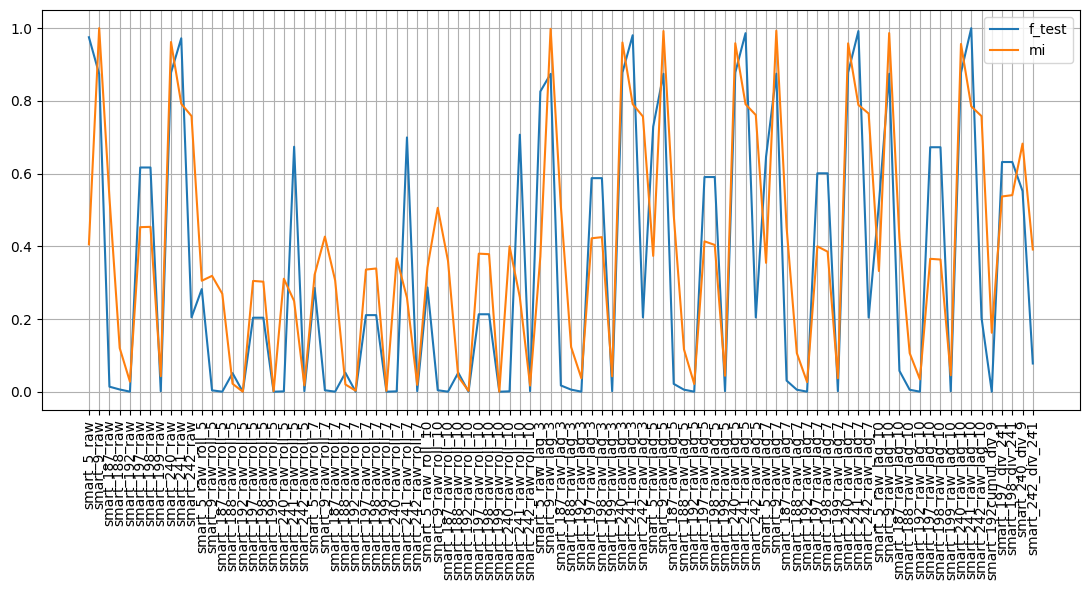

In [ ]:
plt.figure(figsize=(11., 6))
plt.plot(f_selected, label="f_test")
plt.xticks(ticks=range(len(num_cols)), labels=num_cols, rotation=90)
plt.plot(mi_selected, label="mi")
plt.legend()
plt.grid()
plt.tight_layout()

In [137]:
stats_feat_sel = np.array(num_cols)[(f_selected > 0.7) | (mi_selected > 0.7)].tolist()
ftest_feat = np.array(num_cols)[f_selected > 0.7]
mitest_feat = np.array(num_cols)[mi_selected > 0.7]
paper_feat_sel = [
    col for name in [
        "smart_5_raw", "smart_187_raw", "smart_188_raw", "smart_197_raw", "smart_198_raw"
       ] for col in num_cols if col.startswith(name)

]

* del smart_198_raw due to the fact that it's strongly correlated with smart_197_raw
and the last one has a bit more dependence to failure

* del smart_240_raw and take smart_9_raw to replace it

<Axes: >

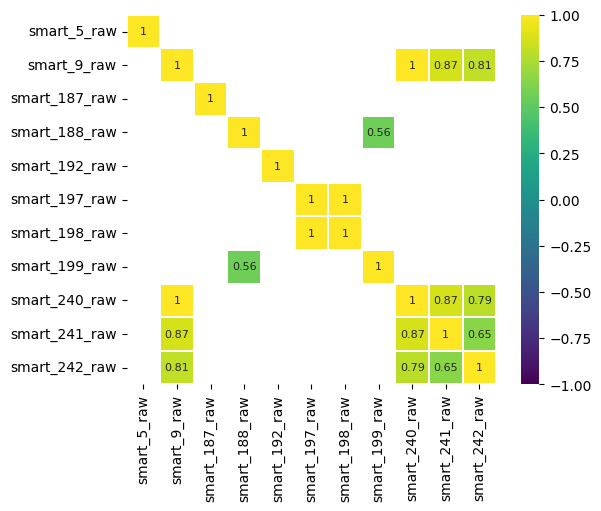

In [ ]:
correlated = x_train[
    [
        'smart_5_raw', 'smart_9_raw', 'smart_187_raw', 'smart_188_raw',
        'smart_192_raw', 'smart_197_raw', 'smart_198_raw', 'smart_199_raw',
        'smart_240_raw', 'smart_241_raw', 'smart_242_raw'
    ]
].corr()
sns.heatmap(
    correlated[(correlated > 0.5) | (correlated <= -0.5)],
    cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
    annot=True, annot_kws={"size": 8}, square=True
)

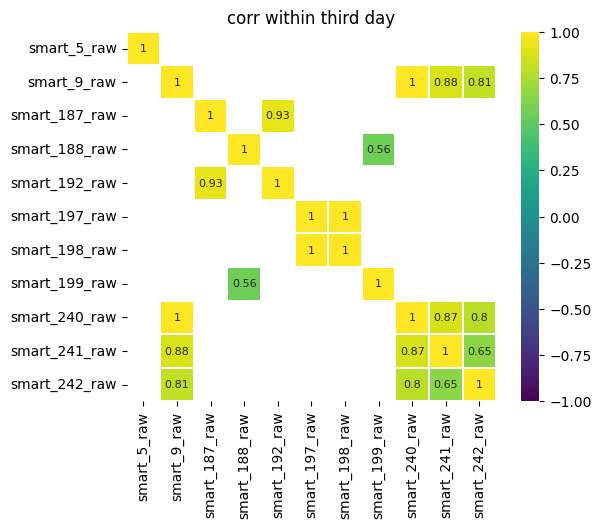

In [66]:
correlated = x_train[
    [
        'smart_5_raw', 'smart_9_raw', 'smart_187_raw', 'smart_188_raw',
        'smart_192_raw', 'smart_197_raw', 'smart_198_raw', 'smart_199_raw',
        'smart_240_raw', 'smart_241_raw', 'smart_242_raw'
    ]
].loc[3].corr()
sns.heatmap(
    correlated[(correlated > 0.5) | (correlated <= -0.5)],
    cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
    annot=True, annot_kws={"size": 8}, square=True
)
plt.title("corr within third day")
plt.show()

In [ ]:
stats_feat_sel = [
    col for col in stats_feat_sel if not col.startswith("smart_240_raw") and \
        not col.startswith("smart_198_raw")
]
paper_feat_sel = [
    col for col in paper_feat_sel if not col.startswith("smart_240_raw") and \
        not col.startswith("smart_198_raw")
]

### Interesting point

Since good disks continue to work, most of their last days of operation are attributed to the latest dates. Because of this, there is a high relationship between the date and the failure of the disk

In [ ]:
df = pd.read_csv("31_days_lag_fix.csv", parse_dates=["date"], index_col=["date"])
df_last_days = pd.read_csv("31_days_lag_fix.csv", parse_dates=["date"], index_col="num_day")

In [ ]:
df_last_days['year'] = df.index.year - 2020
df_last_days['quarter'] = df.index.quarter
df_last_days['month'] = df.index.month
df_last_days['day'] = df.index.day
df_last_days['dayofweek'] = df.index.dayofweek

In [ ]:
x_train, x_val, x_test, y_train, y_val, y_test = TrainValTestSplit(df_last_days)
num_cols = x_train.select_dtypes(np.number).columns.to_list()

In [ ]:
f_selected, p_val = f_classif(x_train[num_cols], y_train)
f_selected /= np.max(f_selected)
mi_selected = mutual_info_classif(x_train[num_cols], y_train, n_neighbors=7, n_jobs=-1)
mi_selected /= np.max(mi_selected)

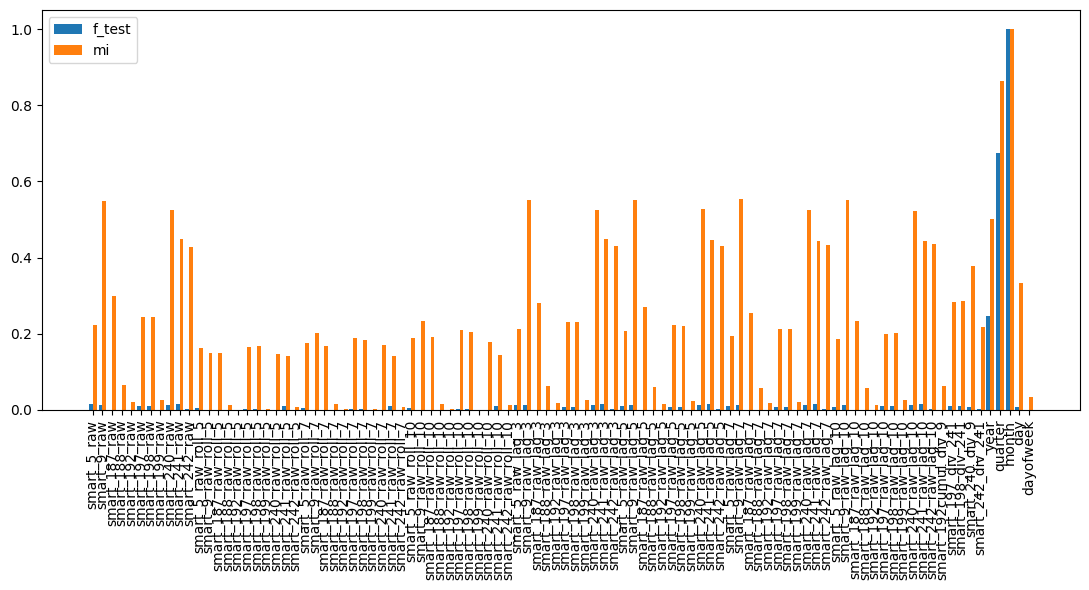

In [ ]:
plt.figure(figsize=(11., 6))
plt.bar(np.arange(len(f_selected)) - 0.2, f_selected, width=0.4, label="f_test")
plt.bar(np.arange(len(f_selected)) + 0.2, mi_selected, width=0.4, label="mi")
plt.xticks(ticks=np.arange(len(num_cols)), labels=num_cols, rotation=90)
plt.legend()
plt.tight_layout()

In [ ]:
sum(mi_selected > 0.4), sum(f_selected > 0.4)

(np.int64(23), np.int64(2))

In [ ]:
df_last_days.month.value_counts()

month
12    333151
10       603
6        589
11       584
4        555
7        527
9        510
5        421
8        365
3        330
2        311
1        295
Name: count, dtype: int64

In [ ]:
df_last_days.quarter.value_counts()

quarter
4    334338
2      1565
3      1402
1       936
Name: count, dtype: int64

### Select from model

In [ ]:
logistic_feat_sel = SelectFromModel(LogisticRegression(
    "elasticnet", class_weight="balanced", solver="saga", max_iter=600, C=0.8,
    l1_ratio=0.3
)).fit(x_train.loc[:, num_cols], y_train).get_feature_names_out(num_cols)
logistic_feat_sel

In [ ]:
logistic_feat_sel_1d = SelectFromModel(LogisticRegression(
    "elasticnet", class_weight="balanced", solver="saga", max_iter=600, C=0.8,
    l1_ratio=0.3
)).fit(x_train.loc[1, num_cols], y_train.iloc[:x_train.loc[1].shape[0]]).get_feature_names_out(num_cols)
logistic_feat_sel_1d

In [ ]:
xtrain, xtest, ytrain, ytest = TrainValTestSplit(x_train, y_train)

dtrain = DMatrix(xtrain, label=ytrain)
dtest = DMatrix(xtest, label=ytest)

params = {
    'objective': 'binary:logistic',
    'max_depth': 6,
    'learning_rate': 0.1,
    'eval_metric': 'auc',
    'reg_alpha': 0.15,
    'tree_method': 'exact'
}

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=200,
    evals=[(dtrain, "train"), (dtest, "eval")],
    early_stopping_rounds=10,
    verbose_eval=50
)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

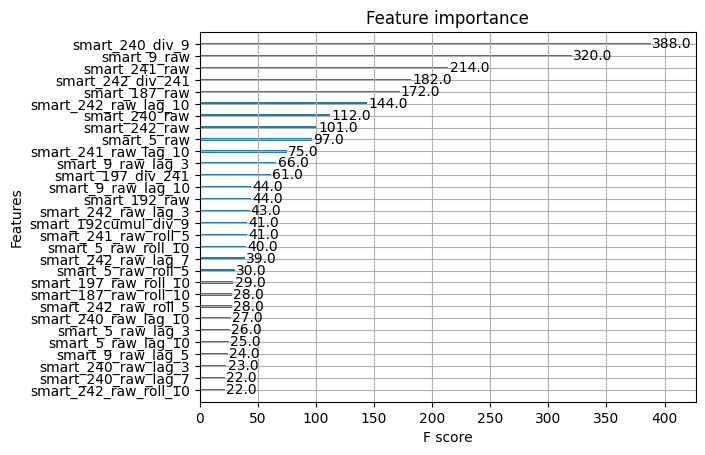

In [ ]:
xgb.plot_importance(bst, max_num_features=30)

In [ ]:
weight = sorted(bst.get_score(importance_type="weight").items(), key=lambda x: -x[1])
weight = [feature for feature, val in weight[:len(weight) // 3]]
gain = sorted(bst.get_score(importance_type="gain").items(), key=lambda x: -x[1])
gain = [feature for feature, val in gain[:len(gain) // 3]]
total_gain = sorted(bst.get_score(importance_type="total_gain").items(), key=lambda x: -x[1])
total_gain = [feature for feature, val in total_gain[:len(total_gain) // 3]]
cover = sorted(bst.get_score(importance_type="cover").items(), key=lambda x: -x[1])
cover = [feature for feature, val in cover[:len(cover) // 3]]

In [ ]:
xtrain, xtest, ytrain, ytest = TrainValTestSplit(x_train.loc[3], y_train.loc[3])

dtrain = DMatrix(xtrain, label=ytrain)
dtest = DMatrix(xtest, label=ytest)

params = {
    'objective': 'binary:logistic',
    'max_depth': 6,
    'learning_rate': 0.1,
    'eval_metric': 'auc',
    'reg_alpha': 0.15,
    'tree_method': 'exact'
}

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=200,
    evals=[(dtrain, "train"), (dtest, "eval")],
    early_stopping_rounds=10,
    verbose_eval=50
)

weight_1d = sorted(bst.get_score(importance_type="weight").items(), key=lambda x: -x[1])
weight_1d = [feature for feature, val in weight_1d[:len(weight_1d) // 3]]
gain_1d = sorted(bst.get_score(importance_type="gain").items(), key=lambda x: -x[1])
gain_1d = [feature for feature, val in gain_1d[:len(gain_1d) // 3]]
total_gain_1d = sorted(bst.get_score(importance_type="total_gain").items(), key=lambda x: -x[1])
total_gain_1d = [feature for feature, val in total_gain_1d[:len(total_gain_1d) // 3]]
cover_1d = sorted(bst.get_score(importance_type="cover").items(), key=lambda x: -x[1])
cover_1d = [feature for feature, val in cover_1d[:len(cover_1d) // 3]]

In [60]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.base import ClassifierMixin, BaseEstimator

class SklearnXGB(ClassifierMixin, BaseEstimator):

    def __init__(self):
        super().__init__()
        self.model = XGBClassifier(
            max_depth=6, reg_alpha=0.15, learning_rate=0.1, tree_method="hist",
            n_estimators=100
        )
    
    def _more_tags(self):
        return {"non_deterministic": True, "poor_score": True}

    def __sklearn_tags__(self):
        return BaseEstimator().__sklearn_tags__()

    def fit(self, X_train, y_train):
        self._is_fitted = True
        self.model.fit(X_train, y_train)
        return self
    
    def predict(self, X_test):
        return self.model.predict(X_test)
    
    def predict_proba(self, X_test):
        return self.model.predict_proba(X_test)

In [ ]:
selector = SequentialFeatureSelector(
    SklearnXGB(), n_features_to_select=17, scoring="roc_auc", cv=CVSplitter(2), n_jobs=-1
)
selector.fit(x_train.loc[:, num_cols], y_train)
selector.get_feature_names_out(num_cols)

## Dimensionality reduction

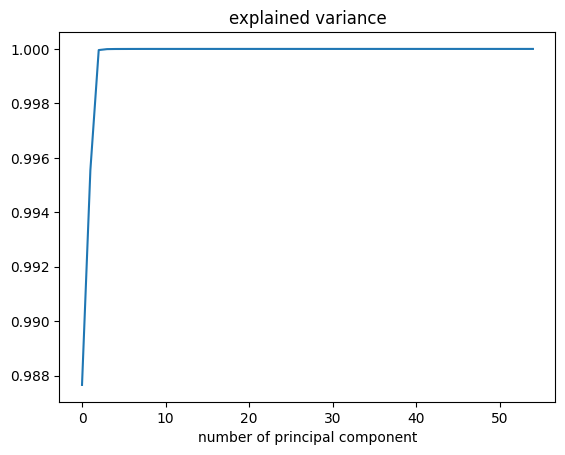

[0.98765971 0.99554331 0.99995792 0.99999252 0.99999722 0.99999817
 0.99999898 0.99999943 0.99999971 0.99999986 0.99999991 0.99999996
 0.99999999 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.        ]


In [ ]:
pca = PCA()
pca.fit(x_train[num_cols])
explained_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(explained_var)
plt.title("explained variance")
plt.xlabel("number of principal component");
plt.show()
print(explained_var)

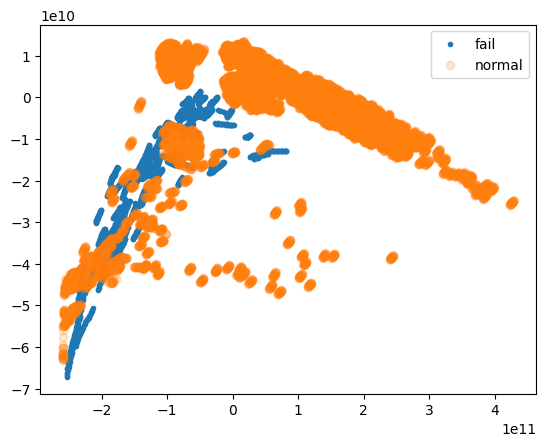

In [ ]:
pca = PCA()
pca.fit(x_train[num_cols])
plt.scatter(
    pca.transform(x_train.loc[y_train == 1, num_cols])[:, 0],
    pca.transform(x_train.loc[y_train == 1, num_cols])[:, 1],
    label="fail", marker="."
);
plt.scatter(
    pca.transform(x_train.loc[y_train == 0, num_cols])[:, 0],
    pca.transform(x_train.loc[y_train == 0, num_cols])[:, 1],
    label="normal", marker="o", alpha=0.2
);
plt.legend()
plt.show()

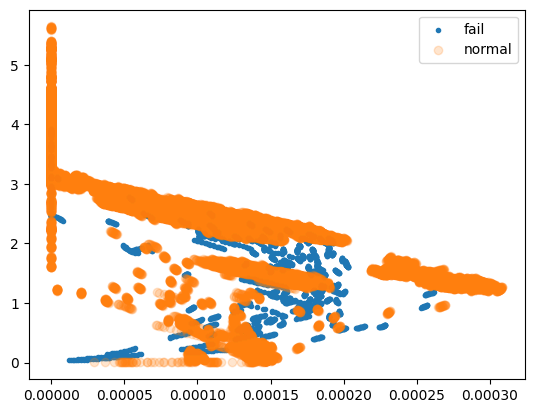

In [ ]:
from sklearn.decomposition import NMF

nmf = NMF(2)
nmf.fit(x_train[num_cols])
plt.scatter(
    nmf.transform(x_train.loc[y_train == 1, num_cols])[:, 0],
    nmf.transform(x_train.loc[y_train == 1, num_cols])[:, 1],
    label="fail", marker="."
);
plt.scatter(
    nmf.transform(x_train.loc[y_train == 0, num_cols])[:, 0],
    nmf.transform(x_train.loc[y_train == 0, num_cols])[:, 1],
    label="normal", marker="o", alpha=0.2
);
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_factor_analysis.py:296: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  warnings.warn(


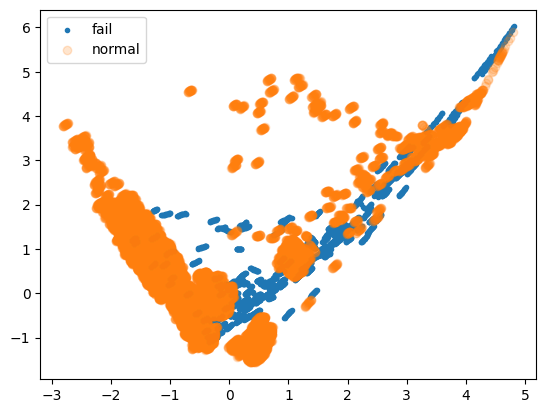

In [ ]:
from sklearn.decomposition import FactorAnalysis

fa = FactorAnalysis(2, max_iter=100)
fa.fit(x_train[num_cols])
plt.scatter(
    fa.transform(x_train.loc[y_train == 1, num_cols])[:, 0],
    fa.transform(x_train.loc[y_train == 1, num_cols])[:, 1],
    label="fail", marker="."
);
plt.scatter(
    fa.transform(x_train.loc[y_train == 0, num_cols])[:, 0],
    fa.transform(x_train.loc[y_train == 0, num_cols])[:, 1],
    label="normal", marker="o", alpha=0.2
);
plt.legend()
plt.show()

## Class balancing

In [ ]:
adasyn = ADASYN(n_neighbors=10, random_state=42, sampling_strategy="minority")
x_resampled, y_resampled = adasyn.fit_resample(x_train[num_cols], y_train)
y_resampled.value_counts()

In [ ]:
kmeanssmote = KMeansSMOTE(
    random_state=42, sampling_strategy="minority", cluster_balance_threshold=0.1
)
x_resampled, y_resampled = kmeanssmote.fit_resample(x_train[num_cols], y_train)
y_resampled.value_counts()

failure
0    266352
1    266352
Name: count, dtype: int64

## Model evaluation

Define to use:
* XGBClassifier
* BalancedRandomForestClassifier
* RandomForestClassifier
* IsolationForest
* Blending

In [11]:
df_last_days = pd.read_csv(
    "34_days_lag_fix.csv", parse_dates=["date"],
    index_col="num_day"
)

In [12]:
x_train, x_val, x_test, y_train, y_val, y_test = TrainValTestSplit(df_last_days)

### Stacking

In [13]:
# Created based on egaoharu_kensei's code: https://habr.com/ru/articles/799483/

from joblib import Parallel, delayed
from sklearn.base import BaseEstimator, ClassifierMixin

class StackingClassifier(ClassifierMixin, BaseEstimator):

    def __init__(
      self, estimators: list[tuple[str, any]], final_estimator, blending=False,
      class_balancer=None, n_cv_folds=3, noize_std=0.01, n_jobs=-1
    ):
        if isinstance(estimators, list):
          self.estimators = {name: model for (name, model) in estimators}
        elif isinstance(estimators, dict):
           self.estimators = estimators
        else:
           raise TypeError("incorrect type of `estimators ")
        self.final_estimator = final_estimator
        self.blending = blending
        self.class_balancer = class_balancer
        self.n_cv_folds = n_cv_folds # to avoid error about there isn't n_cv_folds attribute
        self._CVSplitter = CVSplitter(n_cv_folds)
        self.noize_std = noize_std
        self.n_jobs = n_jobs
        self._is_fitted = False

    def _cross_val_predict(self, estimator, X_data, y_data):
        preds = []
        for train, test in self._CVSplitter.split(X_data, y_data):
          X_train = X_data[train]
          X_test = X_data[test]
          y_train = y_data[train]
          # class balancing
          if self.class_balancer is not None:
            X_train, y_train = self.class_balancer.fit_resample(X_train, y_train)
          estimator.fit(X_train, y_train)
          preds.extend(estimator.predict_proba(X_test)[:, 1])
        return preds

    def _X_pred(self, estimator, data):
        if self.blending:
            X_train_v, y_train_v, X_val = data
            self.estimators[estimator].fit(X_train_v, y_train_v)
            return (
                estimator,
                self.estimators[estimator],
                self.estimators[estimator].predict_proba(X_val)[:, 1]
            )
        else:
            X_train, y_train = data
            return None, self._cross_val_predict(
                self.estimators[estimator], X_train, y_train
            )

    def _X_test_pred(self, estimator, data):
        X_train, y_train, X_test = data
        if X_test is not None:
          if self.blending:
            return None, self.estimators[estimator].predict_proba(X_test)[:, 1]
          self.estimators[estimator].fit(X_train, y_train)
          return (
            estimator,
            self.estimators[estimator],
            self.estimators[estimator].predict_proba(X_test)[:, 1]
          )
        if self.blending:
           return None, []
        return (
            estimator,
            self.estimators[estimator].fit(X_train, y_train),
            []
          )

    def _meta_data(self, X_train, y_train, X_test):
        if self.blending:
            #used hold-out cross-validation
            X_train_v, X_val, y_train_v, y_val = train_test_split(
                X_train, y_train, shuffle=False, random_state=42,
                test_size=0.2
            )
            train_data = [X_train_v, y_train_v, X_val]
            test_data = [X_train_v, y_train_v, X_test]
            meta_y_train = y_val
        else:
            train_data = [X_train, y_train]
            test_data = [X_train, y_train, X_test]
            meta_y_train = np.array(
               [y_train[test] for _, test in self._CVSplitter.split(y_train)]
            ).flatten()

        cv_X_train_preds = (delayed(self._X_pred)(est, train_data) for est in self.estimators)

        train_tuples = Parallel(n_jobs=self.n_jobs)(cv_X_train_preds)
        meta_X_train = []
        if self.blending:
          for name, est, train_data in train_tuples:
            self.estimators[name] = est
            meta_X_train.append(train_data)
          meta_X_train = pd.DataFrame(meta_X_train)
        else:
          meta_X_train = pd.DataFrame(
              [train_data for _, train_data in train_tuples]
          )

        meta_X_test = []
        X_test_preds = (delayed(self._X_test_pred)(est, test_data) for est in self.estimators)
        test_tuples = Parallel(n_jobs=self.n_jobs)(X_test_preds)
        if not self.blending:
          for name, est, test_data in test_tuples:
            self.estimators[name] = est
            meta_X_test.append(test_data)
          meta_X_test = pd.DataFrame(meta_X_test)
        else:
          meta_X_test = pd.DataFrame(
              [test_data for _, test_data in test_tuples]
          )
        meta_X_test = meta_X_test.T + np.random.normal(
          0., self.noize_std, meta_X_test.T.shape
        )
           

        # add some noize to improve predictable ability
        meta_X_train = meta_X_train.T + np.random.normal(
            0., self.noize_std, meta_X_train.T.shape
        )
        
        return meta_X_train, meta_y_train, meta_X_test

    def fit_predict(self, X_train, y_train, X_test):
        if isinstance(X_train, pd.DataFrame):
           X_train = X_train.to_numpy()
        if isinstance(y_train, pd.DataFrame):
           y_train = y_train.to_numpy()
        # meta learner or blender
        meta_X_train, meta_y_train, meta_X_test = self._meta_data(X_train, y_train, X_test)
        self.final_estimator = self.final_estimator.fit(meta_X_train, meta_y_train)
        self._is_fitted = True
        return self.final_estimator.predict_proba(meta_X_test)

    def fit(self, X_train, y_train):
        if isinstance(X_train, pd.DataFrame):
           X_train = X_train.to_numpy()
        if isinstance(y_train, pd.DataFrame) or isinstance(y_train, pd.Series):
           y_train = y_train.to_numpy()
        meta_X_train, meta_y_train, _ = self._meta_data(X_train, y_train, None)
        self.final_estimator.fit(meta_X_train, meta_y_train)
        self._is_fitted = True
        return self

    def predict(self, X_test):
        return self.predict_proba(X_test)
    
    def predict_proba(self, X_test):
        meta_X_test = []
        if isinstance(X_test, pd.DataFrame):
           X_test = X_test.to_numpy()
        for est in self.estimators.values():
          meta_X_test.append(est.predict_proba(X_test)[:, 1])
        meta_X_test = np.array(meta_X_test).T
        # add normal noize
        meta_X_test += np.random.normal(0., self.noize_std, meta_X_test.shape)
        return self.final_estimator.predict_proba(meta_X_test)
    
    def __sklearn_is_fitted__(self):
        """
        Check fitted status and return a Boolean value.
        """
        return hasattr(self, "_is_fitted") and self._is_fitted

In [14]:
from sklearn.svm import OneClassSVM
class WrapIsolationForest(IsolationForest):

    def __init__(
            self, n_estimators=100,
            max_samples="auto",
            contamination="auto",
            max_features=1,
            bootstrap=False
    ):
        super().__init__()
        self.model = IsolationForest(
            n_estimators=n_estimators,
            max_samples=max_samples,
            contamination=contamination,
            max_features=max_features,
            bootstrap=bootstrap
        )

    def fit(self, X_data, y_data):
        self.model.fit(X_data, y_data)
        return self
    
    def predict_proba(self, X_data):
        return np.vstack([np.zeros(X_data.shape[0]), self.model.decision_function(X_data)]).T
    
class WrapOneClassSVM(OneClassSVM):

    def __init__(self, max_iter=100):
        super().__init__()
        self.model = OneClassSVM(max_iter=max_iter)

    def fit(self, X_data, y_data):
        self.model.fit(X_data, y_data)
        return self
    
    def predict_proba(self, X_data):
        return np.vstack([np.zeros(X_data.shape[0]), self.model.decision_function(X_data)]).T

In [16]:
estimators = [
    ("xgb", XGBClassifier(max_depth=6, n_estimators=80)),
    ("isol", WrapIsolationForest(n_estimators=100)),
    # ("svm", WrapOneClassSVM(max_iter=5))
]
stacking = StackingClassifier(
    estimators=estimators,
    final_estimator=XGBClassifier(),
    blending=True, noize_std=0.
)
# PreprocessingTest(stacking, df_last_days, need_balancing=False)
xtrain, xtest, ytrain, ytest = TrainValTestSplit(x_train, y_train)
stacking.fit(xtrain, ytrain)
print(roc_auc_score(ytest, stacking.predict_proba(xtest)[:, 1]))

0.9928604644446197


In [49]:
estimators = [
    ("xgb1", XGBClassifier(max_depth=6, n_estimators=70)),
    ("rfc1", RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=3)),
    ("bal_rfc1", BalancedRandomForestClassifier(
        n_estimators=100, n_jobs=-1, sampling_strategy="not majority",
        bootstrap=True, replacement=True, random_state=27
    ))
]
stacking = StackingClassifier(
    estimators=estimators,
    final_estimator=RandomForestClassifier(
        n_estimators=100, n_jobs=-1, random_state=31
    ),
    blending=True
)
PreprocessingTest(stacking, df_last_days, need_balancing=False)

(40589, 3) (40589, 2)
(40589, 3) (40589, 2)
(40589, 3) (40589, 2)
(40589, 3) (40589, 2)
Dimensionality reduction: default
{'pca': np.float64(0.9351309919658743), 'nmf': np.float64(0.5065421406315943), 'fa': np.float64(0.94039665238731), 'default': np.float64(0.9926677407274302)}
(40589, 3) (40589, 2)
(40589, 3) (40589, 2)
(40589, 3) (40589, 2)
(40589, 3) (40589, 2)
(40589, 3) (40589, 2)
(40589, 3) (40589, 2)
(40589, 3) (40589, 2)
(40589, 3) (40589, 2)
(40589, 3) (40589, 2)
(40589, 3) (40589, 2)
(40589, 3) (40589, 2)
(40589, 3) (40589, 2)
(40589, 3) (40589, 2)
(40589, 3) (40589, 2)
(40589, 3) (40589, 2)
Feature selection: default
stats               : 0.9805                 stats_without_lag: 0.97678
stats_without_depend: 0.97562                            paper: 0.85111
paper_without_roll  : 0.85219                paper_without_lag: 0.84756
paper_without_depend: 0.84959                 elastic_logistic: 0.95101
xgb_weight30        : 0.98966                       xgb_gain30: 0.98812
xgb

In [ ]:
xtrain, xtest, ytrain, ytest = TrainValTestSplit(x_train, y_train)

def objective(trial):
    estimators = [
        ("xgb1", XGBClassifier(
            max_depth=trial.suggest_int("xgb_max_depth", 4, 10),
            n_estimators=trial.suggest_int("xgb_n_estimators", 50, 200, step=10)
        )),
        ("rfc1", RandomForestClassifier(
            n_estimators=trial.suggest_int("rfc_n_estimators", 50, 200, step=10),
            n_jobs=-1, random_state=3, class_weight="balanced"
        )),
        ("bal_rfc1", BalancedRandomForestClassifier(
            n_estimators=trial.suggest_int("bal_rfc_n_estimators", 50, 200, step=10),
            n_jobs=-1, sampling_strategy="not majority",
            bootstrap=True, replacement=True, random_state=27
        ))
    ]
    stacking = StackingClassifier(
        estimators=estimators,
        final_estimator=RandomForestClassifier(
            n_estimators=trial.suggest_int("final_n_estimators", 50, 400, step=10),
            n_jobs=-1, random_state=31, class_weight="balanced"
        ),
        blending=True
    )

    stacking.fit(xtrain, ytrain)
    return roc_auc_score(ytest, stacking.predict(xtest))


stacking_study = optuna.create_study(direction="maximize")
stacking_study.optimize(objective, n_trials=100, gc_after_trial=True)

In [48]:
stacking_params = {
    'xgb_max_depth': 4, 'xgb_n_estimators': 160, 'rfc_n_estimators': 160,
    'bal_rfc_n_estimators': 180, 'final_n_estimators': 50
}
estimators = [
    ("xgb1", XGBClassifier(
        max_depth=stacking_params["xgb_max_depth"],
        n_estimators=stacking_params["xgb_n_estimators"]
    )),
    ("rfc1", RandomForestClassifier(
        n_estimators=stacking_params["rfc_n_estimators"],
        n_jobs=-1, random_state=3, class_weight="balanced"
    )),
    ("bal_rfc1", BalancedRandomForestClassifier(
        n_estimators=stacking_params["bal_rfc_n_estimators"],
        n_jobs=-1, sampling_strategy="not majority",
        bootstrap=True, replacement=True, random_state=27
    ))
]
stacking = StackingClassifier(
    estimators=estimators,
    final_estimator=RandomForestClassifier(
        n_estimators=stacking_params["final_n_estimators"],
        n_jobs=-1, random_state=31, class_weight="balanced"
    ),
    blending=True, noize_std=0.001
)
stacking.fit(x_train, y_train)
print("train", roc_auc_score(y_train, stacking.predict(x_train)))
print("val", roc_auc_score(y_val, stacking.predict(x_val)))

train 0.9988946839345899
val 0.9912977903548829


In [64]:
adasyn = ADASYN(n_neighbors=10, random_state=42, sampling_strategy='minority')

xtrain, xtest, ytrain, ytest = TrainValTestSplit(x_train, y_train)
x_train_res, y_train_res = adasyn.fit_resample(xtrain.loc[:, FEATURE_LIST["default_custom"]], ytrain)

estimators = [
      ("xgb1", XGBClassifier(
              max_depth=6,
              n_estimators=90,
              scale_pos_weight=100.
      )),
      ("xgb2", XGBClassifier(
              max_depth=6,
              n_estimators=40,
              scale_pos_weight=100.
      )),
      ("xgb3", XGBClassifier(
              max_depth=5,
              n_estimators=60,
              scale_pos_weight=100.
      ))
]
xgb_stacking = StackingClassifier(
      estimators=estimators,
      final_estimator=RandomForestClassifier(
          n_estimators=300, class_weight={0: 1, 1: 100}
      ),
      blending=True, noize_std=0.000005
)

xgb_stacking.fit(
      xtrain.loc[:, FEATURE_LIST["default_custom"]],
      ytrain
)

StackingClassifier(blending=True,
                   estimators={'xgb1': XGBClassifier(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     device=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None,
                                                     grow_policy=None,
                                                     importance_type=None,
                                                     interaction_constraints=...
                                                     max_bin=None,
                                                     max_cat_threshold=None,
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=5,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=60,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...)},
                   final_estimator=RandomForestClassifier(class_weight={0: 1,
                                                                        1: 100},
                                                          n_estimators=300),
                   noize_std=5e-06)

In [65]:
print(roc_auc_score(ytest, xgb_stacking.predict(xtest.loc[:, FEATURE_LIST["default_custom"]])))

0.9991676147145853


In [66]:
print(roc_auc_score(y_val, xgb_stacking.predict(x_val.loc[:, FEATURE_LIST["default_custom"]])))

0.9964763822253655


In [75]:
print(classification_report(
    y_val,
    (xgb_stacking.predict(x_val.loc[:, FEATURE_LIST["default_custom"]]) > 0.5).astype(int)
))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     66588
           1       0.97      0.97      0.97      1060

    accuracy                           1.00     67648
   macro avg       0.99      0.98      0.98     67648
weighted avg       1.00      1.00      1.00     67648



### XGBClassifier

In [166]:
PreprocessingTest(XGBClassifier(), df_last_days)

Dimensionality reduction: default
{'pca': np.float64(0.977569491295517), 'nmf': np.float64(0.4231732665427689), 'fa': np.float64(0.9831039009947192), 'default': np.float64(0.9964923758093676)}
Feature selection: xgb_total_gain30_1_day
stats               : 0.99448                stats_without_lag: 0.99377
stats_without_depend: 0.99497                      f_test_feat: 0.95464
mi_test_feat        : 0.99125                            paper: 0.87015
paper_without_roll  : 0.86984                paper_without_lag: 0.86406
paper_without_depend: 0.87015                 elastic_logistic: 0.98821
elastic_logistic_1st_day: 0.98438                     xgb_weight30: 0.99717
xgb_weight30_1_day  : 0.99761                       xgb_gain30: 0.99623
xgb_gain30_1_day    : 0.99759                 xgb_total_gain30: 0.99758
xgb_total_gain30_1_day: 0.99864                      xgb_cover30: 0.99711
xgb_cover30_1_day   : 0.99278              sequential_selector: 0.9981
default             : 0.99649           

In [20]:
xtrain, xtest, ytrain, ytest = TrainValTestSplit(x_train.loc[:, FEATURE_LIST["default_custom"]], y_train)

adasyn = ADASYN(n_neighbors=10, random_state=42, sampling_strategy='minority')
x_train_res, y_train_res = adasyn.fit_resample(xtrain, ytrain)

dtrain = DMatrix(x_train_res, label=y_train_res)
dtest = DMatrix(xtest, label=ytest)

params = {
    'objective': 'binary:logistic',
    'max_depth': 6,
    'learning_rate': 0.1,
    'eval_metric': 'auc',
    'reg_alpha': 0.15,
    'tree_method': 'exact'
}

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=200,
    evals=[(dtrain, "train"), (dtest, "eval")],
    early_stopping_rounds=20,
    verbose_eval=10
)

In [94]:
print(classification_report(
    ytest,
    (bst.predict(DMatrix(xtest.loc[:, FEATURE_LIST["default_custom"]])) > 0.5).astype(int)
))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39953
           1       0.98      0.98      0.98       636

    accuracy                           1.00     40589
   macro avg       0.99      0.99      0.99     40589
weighted avg       1.00      1.00      1.00     40589



In [95]:
print(roc_auc_score(y_test, bst.predict(DMatrix(x_test.loc[:, FEATURE_LIST["default_custom"]]))))

0.9983249367146729


In [88]:
print(classification_report(
    y_val,
    (bst.predict(DMatrix(x_val.loc[:, FEATURE_LIST["default_custom"]])) > 0.2).astype(int)
))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     66588
           1       0.97      0.98      0.98      1060

    accuracy                           1.00     67648
   macro avg       0.98      0.99      0.99     67648
weighted avg       1.00      1.00      1.00     67648



In [96]:
print(roc_auc_score(y_test, bst.predict(DMatrix(x_test.loc[:, FEATURE_LIST["default_custom"]]))))

0.9978296633193993


In [97]:
print(classification_report(
    y_test,
    (bst.predict(DMatrix(x_test.loc[:, FEATURE_LIST["default_custom"]])) > 0.5).astype(int)
))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     66588
           1       0.89      0.95      0.92      1061

    accuracy                           1.00     67649
   macro avg       0.94      0.97      0.96     67649
weighted avg       1.00      1.00      1.00     67649



In [ ]:
joblib.dump(bst, "fitted_xgb.pkl")

### IsolationForest

In [167]:
PreprocessingTest(IsolationForest(random_state=42), df_last_days, need_balancing=False)

Dimensionality reduction: default
{'pca': np.float64(0.508114930264511), 'nmf': np.float64(0.37729091603541437), 'fa': np.float64(0.7722449297809916), 'default': np.float64(0.9405393771297971)}
Feature selection: xgb_gain30
stats               : 0.92211                stats_without_lag: 0.89759
stats_without_depend: 0.87604                      f_test_feat: 0.89805
mi_test_feat        : 0.84711                            paper: 0.75186
paper_without_roll  : 0.75529                paper_without_lag: 0.77181
paper_without_depend: 0.74974                 elastic_logistic:  0.72
elastic_logistic_1st_day: 0.70696                     xgb_weight30: 0.88907
xgb_weight30_1_day  : 0.86365                       xgb_gain30: 0.93155
xgb_gain30_1_day    : 0.89661                 xgb_total_gain30: 0.90416
xgb_total_gain30_1_day: 0.88764                      xgb_cover30: 0.90825
xgb_cover30_1_day   : 0.87117              sequential_selector: 0.81602
default             : 0.82923              default_w

In [ ]:
x_data = x_train.loc[:, FEATURE_LIST["xgb_total_gain30"]]

def objective(trial):
    iforest = IsolationForest(
        n_estimators=trial.suggest_int("n_estimators", 100, 500, step=10),
        bootstrap=trial.suggest_categorical("bootstrap", [True, False]),
        max_samples=trial.suggest_float("max_samples", 0.1, 1.),
        contamination=trial.suggest_float("contamination", 0.001, 0.1, log=True),
        max_features=trial.suggest_float("max_features", 0.1, 1., log=True),
        n_jobs=-1, random_state=42
    )
    test_val = 0
    for train, test in CVSplitter(2).split(x_data):
        iforest.fit(x_data.iloc[train], y_train.iloc[train])
        # negative values are outliers
        preds = -1 * iforest.score_samples(x_data.iloc[test])
        preds = (preds - np.min(preds)) / (np.max(preds) - np.min(preds))
        test_val += roc_auc_score(y_train.iloc[test], preds)

    return test_val / 2


iforest_study = optuna.create_study(direction="maximize")
iforest_study.optimize(objective, n_trials=300)

In [24]:
print(iforest_study.best_params)
iforest = IsolationForest(n_jobs=-1, random_state=42).set_params(**iforest_study.best_params)
iforest.fit(x_train.loc[:, FEATURE_LIST["xgb_total_gain30"]], y_train)
preds = -1 * iforest.score_samples(x_train.loc[:, FEATURE_LIST["xgb_total_gain30"]])
preds = (preds - np.min(preds)) / (np.max(preds) - np.min(preds))
print("train", roc_auc_score(y_train, preds))
preds = -1 * iforest.score_samples(x_val.loc[:, FEATURE_LIST["xgb_total_gain30"]])
preds = (preds - np.min(preds)) / (np.max(preds) - np.min(preds))
print("val", roc_auc_score(y_val, preds))

{'n_estimators': 370, 'bootstrap': True, 'max_samples': 0.1650279100438644, 'contamination': 0.00961418563824092, 'max_features': 0.1133458404681827}
train 0.9888747401178671
val 0.9697634907303824


### BalancedRandomForestClassifier

In [168]:
PreprocessingTest(
    BalancedRandomForestClassifier(random_state=42), df_last_days, need_balancing=False
)

Dimensionality reduction: default
{'pca': np.float64(0.9573442280938989), 'nmf': np.float64(0.6321017099059474), 'fa': np.float64(0.978539592441912), 'default': np.float64(0.9975500539821708)}
Feature selection: default
stats               : 0.99515                stats_without_lag: 0.99404
stats_without_depend: 0.99618                      f_test_feat: 0.98492
mi_test_feat        : 0.98642                            paper: 0.86941
paper_without_roll  : 0.86952                paper_without_lag: 0.86413
paper_without_depend: 0.8697                  elastic_logistic: 0.98249
elastic_logistic_1st_day: 0.98696                     xgb_weight30: 0.99703
xgb_weight30_1_day  : 0.99678                       xgb_gain30: 0.9971
xgb_gain30_1_day    : 0.99739                 xgb_total_gain30: 0.9967
xgb_total_gain30_1_day: 0.99717                      xgb_cover30: 0.99658
xgb_cover30_1_day   : 0.99485              sequential_selector: 0.99697
default             : 0.99755              default_witho

In [ ]:
x_data = x_train.loc[:, FEATURE_LIST["default"]]

def objective(trial):
    bal_forest = BalancedRandomForestClassifier(
        n_estimators=trial.suggest_int("n_estimators", 100, 400, step=5),
        max_features=trial.suggest_float("max_features", 0.1, 0.9, log=True),
        class_weight=trial.suggest_categorical(
            "class_weight", ["balanced", "balanced_subsample"]
        ),
        sampling_strategy=trial.suggest_categorical(
            "sampling_strategy", ["not majority"]
        ),
        n_jobs=trial.suggest_categorical("n_jobs", [-1]),
        random_state=trial.suggest_categorical("random_state", [42]),
        replacement=trial.suggest_categorical("replacement", [True]),
        bootstrap=trial.suggest_categorical("bootstrap", [True])
    )
    test_val = 0
    n_splits = 2
    for train, test in CVSplitter(n_splits).split(x_data):
        bal_forest.fit(x_data.iloc[train], y_train.iloc[train])
        test_val += roc_auc_score(y_train.iloc[test], bal_forest.predict_proba(x_data.iloc[test])[:, 1])

    return test_val / n_splits


bal_forest_study = optuna.create_study(direction="maximize")
bal_forest_study.optimize(objective, n_trials=350)
print(bal_forest_study.best_params)

In [26]:
best_params = {
    'n_estimators': 150, 'max_features': 0.10417070542176012,
    'class_weight': 'balanced', 'sampling_strategy': 'not majority',
    'n_jobs': -1, 'random_state': 42, 'replacement': True,
    'bootstrap': True
}
bal_forest = BalancedRandomForestClassifier().set_params(**bal_forest_study.best_params)
bal_forest.fit(x_train.loc[:, FEATURE_LIST["default"]], y_train)
print(roc_auc_score(y_train, bal_forest.predict_proba(x_train.loc[:, FEATURE_LIST["default"]])[:, 1]))
print(roc_auc_score(y_val, bal_forest.predict_proba(x_val.loc[:, FEATURE_LIST["default"]])[:, 1]))

1.0
0.9931667811413694


In [108]:
params =  {
    'n_estimators': 250, 'max_features': 0.14752706691227166, 'class_weight': 'balanced',
    'sampling_strategy': 'not majority', 'n_jobs': -1, 'random_state': 42,
    'replacement': True, 'bootstrap': True
}

In [109]:
bal_forest = BalancedRandomForestClassifier().set_params(**params)
bal_forest.fit(x_train.loc[:, FEATURE_LIST["default_custom"]], y_train)

BalancedRandomForestClassifier(bootstrap=True, class_weight='balanced',
                               max_features=0.14752706691227166,
                               n_estimators=250, n_jobs=-1, random_state=42,
                               sampling_strategy='not majority')

In [111]:
print(roc_auc_score(y_train, bal_forest.predict_proba(x_train.loc[:, FEATURE_LIST["default_custom"]])[:, 1]))
print(roc_auc_score(y_val, bal_forest.predict_proba(x_val.loc[:, FEATURE_LIST["default_custom"]])[:, 1]))

1.0
0.9942892424381525


### RandomForestClassifier

In [169]:
PreprocessingTest(RandomForestClassifier(random_state=42), df_last_days)

Dimensionality reduction: default
{'pca': np.float64(0.9413965895015306), 'nmf': np.float64(0.3531057433979335), 'fa': np.float64(0.9729046658962809), 'default': np.float64(0.9957719442310793)}


KeyboardInterrupt: 

In [ ]:
def objective(trial):
  rfc = RandomForestClassifier(
      n_estimators=trial.suggest_int("n_estimators", 50, 510, step=20),
      max_depth=trial.suggest_int("max_depth", 3, 30),
      min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 7),
      min_samples_split=trial.suggest_int("min_samples_split", 2, 8),
      class_weight="balanced", random_state=42, n_jobs=-1
  )
  return CrossValScore(
    rfc, x_train.loc[:, FEATURE_LIST["xgb_weight30"]], y_train, n_cv_folds=2
  )

rfc_study = optuna.create_study(study_name="random forest", direction="maximize")
rfc_study.optimize(objective, n_trials=400, gc_after_trial=True)
print(rfc_study.best_params)

In [30]:
rfc_params = {'n_estimators': 410, 'max_depth': 28, 'min_samples_leaf': 1, 'min_samples_split': 3}
rfc = RandomForestClassifier(
    random_state=42, n_jobs=-1, class_weight="balanced"
).set_params(**rfc_params)
rfc.fit(x_train.loc[:, FEATURE_LIST["xgb_weight30"]], y_train)
print(
    "train roc_auc: "
    f"{roc_auc_score(y_train, rfc.predict_proba(x_train.loc[:, FEATURE_LIST["xgb_weight30"]])[:, 1]):.5f}"
)
print(
    "val roc_auc: "
    f"{roc_auc_score(y_val, rfc.predict_proba(x_val.loc[:, FEATURE_LIST["xgb_weight30"]])[:, 1]):.5f}"
)

train roc_auc: 1.00000
val roc_auc: 0.99515
